In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn import utils
from scipy import stats
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def relativize_time(df):
    df = df.copy()
    rel_time = []
    t = df.groupby(['study_name', 'website_call']).agg({'start_time': lambda x: min(x.tolist())})
    
    for (study_name, website_call), row in t.iterrows():
        s = df.query(f"study_name == '{study_name}' & website_call == '{website_call}'")['rel_time']
        rel_time.append(s.apply(lambda x: [round(p - row['start_time'], 5) for p in x]))
        
        
    df['rel_time'] = pd.concat(rel_time)
    df['start_time'] =  df['rel_time'].apply(min)
    df['end_time'] =  df['rel_time'].apply(max)
    
    return df

# set seed
random.seed(0)
np.random.seed(0)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

PREPROCESSED = Path('../data/preprocessed')
ASSETS = Path ('../assets/majestic-1000')
CHART_FILE_EXTENSION = ".svg"

df = pd.read_csv(PREPROCESSED / 'resources.csv')

cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time', 'incoming', 'incoming_sizes', 'outgoing', 'outgoing_sizes']
for col in cols:
    df[col] = df[col].apply(eval)

df = relativize_time(df)
df.head()

,id,url,connection_id,ip,org,protocol,method,website_call,start,end_header,end_stream,content,type,first_party,context,ip_context,packets,hostname,is_tp,study_name,is_tracker,filter,sizes,ip_src,ip_dst,rel_time,start_time,end_time,delta_req_time,incoming,incoming_sizes,outgoing,outgoing_sizes
0,5093fa6586418f28e0069fabb2c6b0c59f39363ef610d6c03ce525f6,https://mozilla.org/,92cae6a227d9578f82c435923b96e57376109d5ebeaf82579a567df1,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,before accept,False,NaN,"[347, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.0, 0.19056]",0.00000,0.19056,0.000000,[26],[435],[20],[347]
1,44fb20d146dca8a9e9639f20d087212cda626632bbd00e8b86cd343d,https://mozilla.org/,c7479fa7a53b20525b11f449e9455477fe68593d6c4f0b10fc2c6e21,44.236.72.93,"Amazon.com, Inc.",http2,GET,mozilla.org,20,26.0,26.0,text/html,document,www.mozilla.org,mozilla.org,13.32.119.185,"[20, 26]",mozilla.org,False,accepting policy,False,NaN,"[454, 435]","[172.17.0.4, 44.236.72.93]","[44.236.72.93, 172.17.0.4]","[0.0, 0.19239]",0.00000,0.19239,0.000000,[26],[435],[20],[454]
2,e04f654413fb8adf213140727b8b4c6691c472d6e12b56348a272999,https://www.mozilla.org/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,51,61.0,NaN,text/html; charset=utf-8,document,www.mozilla.org,mozilla.org,13.32.119.185,"[51, 59, 61]",mozilla.org,False,before accept,False,NaN,"[351, 1460, 305]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.2567, 0.2717, 0.2717]",0.25670,0.27170,0.000000,"[59, 61]","[1460, 305]",[51],[351]
3,815a3078fff2a4cd95623602374ca6ff1b6cf1628e368dd60e1dc44b,https://www.mozilla.org/en-US/,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,65,81.0,84.0,text/html; charset=utf-8,document,www.mozilla.org,mozilla.org,13.32.119.185,"[65, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]",mozilla.org,False,before accept,False,NaN,"[56, 1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]","[172.17.0.4, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4, 172.17.0.4]","[0.27298, 0.28897, 0.28914, 0.28915, 0.28915, 0.28915, 0.28946, 0.28948, 0.28948, 0.28948, 0.28948, 0.29036, 0.29037, 0.29037, 0.29037, 0.29037]",0.27298,0.29037,0.016286,"[67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84]","[1460, 1460, 1460, 1332, 1428, 1460, 1460, 1460, 1460, 1300, 1460, 1460, 1460, 1332, 1352]",[65],[56]
4,5d10a4d49a66e53dc9ab3aa886139668faa92c3ee3bbcba0c059a982,https://www.mozilla.org/media/js/site.7afc1ba3aa92.js,85078c64ce9bc06db10b2c8145746daeb5e20b3f71eb45168a14fa64,13.32.119.185,"Amazon.com, Inc.",http2,GET,mozilla.org,86,108.0,108.0,application/javascript,script,www.mozilla.org,mozilla.org,13.32.119.185,"[86, 107, 108]",mozilla.org,False,before accept,False,NaN,"[163, 1460, 1240]","[172.17.0.4, 13.32.119.185, 13.32.119.185]","[13.32.119.185, 172.17.0.4, 172.17.0.4]","[0.30264, 0.31768, 0.31769]",0.30264,0.31769,0.029657,"[107, 108]","[1460, 1240]",[86],[163]


## Feature Engineering

In [2]:
def split_by_webpage(df, test_size=0.2):
    websites = df['website_call'].unique().tolist()
    test_websites = random.sample(websites, math.ceil(test_size*len(websites)))
    train = utils.shuffle(df[~df['website_call'].isin(test_websites)])
    test = utils.shuffle(df[df['website_call'].isin(test_websites)])
    return train, test

df_train, df_test = split_by_webpage(df, test_size=0.3)

In [3]:
def remove_dupl(row):
    packets = pd.Series(row['packets'], dtype='object').drop_duplicates()
    incoming = pd.Series(row['incoming'], dtype='object').drop_duplicates()
    outgoing = pd.Series(row['outgoing'], dtype='object').drop_duplicates()
    
    sizes = [row['sizes'][i] for i in packets.index]
    rel_time = [row['rel_time'][i] for i in packets.index]
    
    incoming_sizes = [row['incoming_sizes'][i] for i in incoming.index]
    outgoing_sizes = [row['outgoing_sizes'][i] for i in outgoing.index]
    
    return pd.Series([packets.tolist(), incoming.tolist(), outgoing.tolist(), sizes, incoming_sizes, outgoing_sizes, rel_time])

In [4]:
import warnings
    
def train_prevalence_ip(df):
    # len_unique_fp = len(df['first_party'].unique())
    prevalence = df.groupby('ip').apply(lambda gp: len(gp['first_party'].unique()))
    prevalence.name = 'ip_prevalence'
    return prevalence

def min_coll(collection):
    return np.min(collection) if len(collection) > 0 else None

def max_coll(collection):
    return np.max(collection) if len(collection) > 0 else None

def descriptive_statistics(df, col, level='R', precision=3, agg=None):
    X = pd.DataFrame()
    s = df[col] if agg is None else df[col].apply(lambda x: [agg(rs) for rs in x])
    col_name = lambda col, f: f"{level}:{f}({col})"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        
        X[col_name(col, "sum")] = s.apply(lambda x: np.sum(x)).round(precision)
        X[col_name(col, "mean")] = s.apply(lambda x: np.mean(x)).round(precision)
        X[col_name(col, "rsd")] = s.apply(lambda x: np.std(x) / np.mean(x)).round(precision)
        X[col_name(col, "min")] = s.apply(min_coll).round(precision)
        X[col_name(col, "max")] = s.apply(max_coll).round(precision)
        X[col_name(col, "span")] = X[col_name(col, "max")] - X[col_name(col, "min")]
    
    return X

def remove_dupl(row):
    packets = pd.Series(row['packets'], dtype='object').drop_duplicates()
    incoming = pd.Series(row['incoming'], dtype='object').drop_duplicates()
    outgoing = pd.Series(row['outgoing'], dtype='object').drop_duplicates()
    
    sizes = [row['sizes'][i] for i in packets.index]
    rel_time = [row['rel_time'][i] for i in packets.index]
    
    incoming_sizes = [row['incoming_sizes'][i] for i in incoming.index]
    outgoing_sizes = [row['outgoing_sizes'][i] for i in outgoing.index]
    
    return pd.Series([packets.tolist(), incoming.tolist(), outgoing.tolist(), sizes, incoming_sizes, outgoing_sizes, rel_time])
  
def extract_communication_features(df, prevalence_ip=None, resource_inf_available=True):
    gp = df.groupby(['study_name', 'website_call', 'ip'])
    if resource_inf_available:
        rs_tolist = lambda x: x.tolist()
    else:
        rs_tolist =  lambda x: [p for r in x.tolist() for p in r]
        
    fns = {col: rs_tolist for col in ['packets', 'incoming', 'outgoing', 'sizes', 'incoming_sizes', 'outgoing_sizes', 'rel_time']}
    communication = gp.agg(fns | {'delta_req_time': lambda rs: rs.tolist(), 'org': lambda rs: rs.tolist()[0]})    
        
    if resource_inf_available:
        rename = {'outgoing': 'out packets', 'outgoing_sizes': 'out resource sizes', 'sizes': 'resource sizes',
                'incoming': 'in packets', 'incoming_sizes': 'in resource sizes', 'rel_time': 'rel time', 
                'delta_req_time': 'delta resource time'}
    else:
        rename = {'outgoing': 'out packets', 'outgoing_sizes': 'out packet sizes', 'sizes': 'packet sizes',
                'incoming': 'in packets', 'incoming_sizes': 'in packet sizes', 'rel_time': 'rel time', 
                'delta_req_time': 'delta resource time'}
        
        # since multiplexing in http2 multiple resources can be transmitted via same tcp
        cols = ['packets', 'incoming', 'outgoing', 'sizes', 'incoming_sizes', 'outgoing_sizes', 'rel_time']
        communication[cols] = communication[cols].apply(remove_dupl, axis=1)
    
    communication_r = communication.rename(columns=rename)
    
    X = pd.DataFrame()
    
    cols = ['packets', 'in packets', 'out packets']
    if resource_inf_available:
        X['C:count(resources)'] = communication['packets'].apply(len)
        for col in cols:
            X[f"C:count({col})"] = communication_r[col].apply(lambda x: len([p for rs in x for p in rs]))
    else:
        for col in cols:
            X[f"C:count({col})"] = communication_r[col].apply(len)
           
    
    if resource_inf_available:
        cols = ['resource sizes', 'in resource sizes', 'out resource sizes']
        for col in cols:
            X = pd.concat([X, descriptive_statistics(communication_r, col, level='C', agg=sum)], axis=1)
        
        X = pd.concat([X, descriptive_statistics(communication_r, 'rel time', level='C', agg=min)], axis=1)
        X = pd.concat([X, descriptive_statistics(communication_r, 'delta resource time', level='C')], axis=1)
    
    else:
        cols = ['packet sizes', 'in packet sizes', 'out packet sizes']
        for col in cols:
            X = pd.concat([X, descriptive_statistics(communication_r, col, level='C')], axis=1)
            
        X = pd.concat([X, descriptive_statistics(communication_r, 'rel time', level='C')], axis=1)
        
        
    #X['C:enc(ip)'] = communication.index.get_level_values(2).factorize()[0]
    #X['C:enc(org)'] = communication['org'].factorize()[0]
    #ips = pd.DataFrame(communication.index.get_level_values(2).str.split('.').tolist(), index=communication.index, columns=['C:ip[0]', 'C:ip[1]', 'C:ip[2]', 'C:ip[3]']).astype(int)
    #X = pd.concat([X, ips], axis=1)
    if prevalence_ip is not None:
        communication = communication.join(prevalence_ip, on='ip')
        X['C:prevalence(ip)'] = communication['ip_prevalence']
        
    #X.drop(columns=['C:min(delta resource time)', 'C:span(delta resource time)', 'C:sum(rel time)'], inplace=True)
    cols = X.columns
    X = df.merge(X, left_on=['study_name', 'website_call', 'ip'], right_index=True)
    X = X.loc[df.index]
    
    return X[cols].fillna(-1)

def extract_resource_features(df):
    df_r = df.rename(columns={'outgoing': 'out packets', 'outgoing_sizes': 'out packet sizes', 'sizes': 'packet sizes',
                                                    'incoming': 'in packets', 'incoming_sizes': 'in packet sizes',
                                                    'rel_time': 'rel time'})
    
    X = pd.DataFrame()
    cols = ['packets', 'in packets', 'out packets']
    for col in cols:
        X[f"R:count({col})"] = df_r[col].apply(len)
    
    cols = ['packet sizes', 'in packet sizes', 'out packet sizes', 'rel time']
    for col in cols:
        X = pd.concat([X, descriptive_statistics(df_r, col, level='R')], axis=1)
        
    X['R:delta resource time'] = df['delta_req_time']
    # X.drop(columns=['R:sum(rel time)'], inplace=True)
    
    return X.fillna(-1)

def extract_features(df, prevalence_ip=None, feature_names=False, resource_inf_available=True):
    com_features = extract_communication_features(df, prevalence_ip, resource_inf_available)
    res_features = extract_resource_features(df)
    
    X = pd.concat([com_features, res_features], axis=1)
    
    if feature_names:
        return X, {'communication': com_features.columns, 'resource': res_features.columns}
    else:
        return X

prevalence_ip = train_prevalence_ip(df_train)
X_train, feature_names = extract_features(df_train, prevalence_ip, feature_names=True, resource_inf_available=False)
X_test = extract_features(df_test, prevalence_ip, resource_inf_available=False)
y_train, y_test = df_train['is_tracker'], df_test['is_tracker']
X = pd.concat([X_train, X_test]).sort_index()
y_true = df['is_tracker']
X.head()

,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
0,2,1,1,782,391.000,0.113,347,435,88,435.0,435.000,0.000,435.0,435.0,0.0,347,347.000,0.000,347,347,0,0.191,0.095,1.000,0.000,0.191,0.191,1.0,2,1,1,782,391.000,0.113,347,435,88,435.0,435.000,0.000,435.0,435.0,0.0,347.0,347.0,0.0,347.0,347.0,0.0,0.191,0.095,1.000,0.000,0.191,0.191,0.000000
1,2,1,1,889,444.500,0.021,435,454,19,435.0,435.000,0.000,435.0,435.0,0.0,454,454.000,0.000,454,454,0,0.192,0.096,1.000,0.000,0.192,0.192,1.0,2,1,1,889,444.500,0.021,435,454,19,435.0,435.000,0.000,435.0,435.0,0.0,454.0,454.0,0.0,454.0,454.0,0.0,0.192,0.096,1.000,0.000,0.192,0.192,0.000000
2,369,322,47,437023,1184.344,0.416,18,1460,1442,432279.0,1342.481,0.212,18.0,1460.0,1442.0,4744,100.936,0.436,56,351,295,159.146,0.431,0.208,0.257,0.564,0.307,1.0,3,2,1,2116,705.333,0.757,305,1460,1155,1765.0,882.500,0.654,305.0,1460.0,1155.0,351.0,351.0,0.0,351.0,351.0,0.0,0.800,0.267,0.027,0.257,0.272,0.015,0.000000
3,369,322,47,437023,1184.344,0.416,18,1460,1442,432279.0,1342.481,0.212,18.0,1460.0,1442.0,4744,100.936,0.436,56,351,295,159.146,0.431,0.208,0.257,0.564,0.307,1.0,16,15,1,21400,1337.500,0.251,56,1460,1404,21344.0,1422.933,0.041,1300.0,1460.0,160.0,56.0,56.0,0.0,56.0,56.0,0.0,4.618,0.289,0.014,0.273,0.290,0.017,0.016286
4,369,322,47,437023,1184.344,0.416,18,1460,1442,432279.0,1342.481,0.212,18.0,1460.0,1442.0,4744,100.936,0.436,56,351,295,159.146,0.431,0.208,0.257,0.564,0.307,1.0,3,2,1,2863,954.333,0.594,163,1460,1297,2700.0,1350.000,0.081,1240.0,1460.0,220.0,163.0,163.0,0.0,163.0,163.0,0.0,0.938,0.313,0.023,0.303,0.318,0.015,0.029657


In [5]:
def calc_entropy(data):
    p_data = np.bincount(data) / len(data)
    return stats.entropy(p_data, base=2)

communications = df.groupby(['study_name', 'website_call', 'ip']).agg({
                                                                     'packets': lambda x: x.tolist(),
                                                                     'sizes': lambda x: x.tolist(),
                                                                     'incoming': lambda x: x.tolist(),
                                                                     'incoming_sizes': lambda x: x.tolist(),
                                                                     'outgoing': lambda x: x.tolist(),
                                                                     'outgoing_sizes': lambda x: x.tolist(),
                                                                     'rel_time': lambda x: x.tolist(),
                                                                     'hostname': lambda x: set(x.tolist()),
                                                                     'is_tp': lambda x: x.all(),
                                                                     'is_tracker': lambda x: x.tolist()})
communications['service_entropy'] = communications['is_tracker'].apply(calc_entropy)
communications['tracking_ratio'] = communications['is_tracker'].apply(lambda x: sum(x) / len(x))
communications['is_tracker_overall'] = communications['tracking_ratio'].apply(lambda x: x >= 0.5)

helper = X[feature_names['communication']].drop_duplicates()
helper = helper.join(df)[list(feature_names['communication']) + ['study_name', 'website_call', 'ip']]
communications = communications.merge(helper, left_index=True, right_on=['study_name', 'website_call', 'ip']).set_index(['study_name', 'website_call', 'ip'])
communications.head(2)

packets  \
study_name       website_call      ip                                                  
accepting policy 1.bp.blogspot.com 172.217.23.100  [[69, 81, 89, 91], [70, 97, 101]]   
                                   216.58.212.161                [[21, 29, 31, 105]]   

                                                                                       sizes  \
study_name       website_call      ip                                                          
accepting policy 1.bp.blogspot.com 172.217.23.100  [[343, 1460, 1460, 786], [95, 1460, 515]]   
                                   216.58.212.161                     [[351, 1460, 632, 70]]   

                                                                    incoming  \
study_name       website_call      ip                                          
accepting policy 1.bp.blogspot.com 172.217.23.100  [[81, 89, 91], [97, 101]]   
                                   216.58.212.161            [[29, 31, 105]]   

                                                                     incoming_sizes  \
study_name       website_call      ip                                                 
accepting policy 1.bp.blogspot.com 172.217.23.100  [[1460, 1460, 786], [1460, 515]]   
                                   216.58.212.161                 [[1460, 632, 70]]   

                                                       outgoing  \
study_name       website_call      ip                             
accepting policy 1.bp.blogspot.com 172.217.23.100  [[69], [70]]   
                                   216.58.212.161        [[21]]   

                                                  outgoing_sizes  \
study_name       website_call      ip                              
accepting policy 1.bp.blogspot.com 172.217.23.100  [[343], [95]]   
                                   216.58.212.161        [[351]]   

                                                                                                             rel_time  \
study_name       website_call      ip                                                                                   
accepting policy 1.bp.blogspot.com 172.217.23.100  [[0.06843, 0.0769, 0.07703, 0.07704], [0.06855, 0.08527, 0.08555]]   
                                   216.58.212.161                                   [[0.0, 0.01767, 0.0177, 1.01875]]   

                                                            hostname  is_tp  \
study_name       website_call      ip                                         
accepting policy 1.bp.blogspot.com 172.217.23.100       {google.com}   True   
                                   216.58.212.161  {bp.blogspot.com}  False   

                                                       is_tracker  \
study_name       website_call      ip                               
accepting policy 1.bp.blogspot.com 172.217.23.100  [False, False]   
                                   216.58.212.161         [False]   

                                                   service_entropy  \
study_name       website_call      ip                                
accepting policy 1.bp.blogspot.com 172.217.23.100              0.0   
                                   216.58.212.161              0.0   

                                                   tracking_ratio  \
study_name       website_call      ip                               
accepting policy 1.bp.blogspot.com 172.217.23.100             0.0   
                                   216.58.212.161             0.0   

                                                   is_tracker_overall  \
study_name       website_call      ip                                   
accepting policy 1.bp.blogspot.com 172.217.23.100               False   
                                   216.58.212.161               False   

                                                   C:count(packets)  \
study_name       website_call      ip                                 
accepting policy 1.bp.blogspot.com 172.217.23.100      

In [6]:
print(f"Train / Test / Total webpages: {len(df_train['website_call'].unique())} / {len(df_test['website_call'].unique())} / {len(df['website_call'].unique())}")
print(f"Train / Test / Total resources: {len(X_train)} / {len(X_test)} / {len(X)}")

Train / Test / Total webpages: 653 / 280 / 933
Train / Test / Total resources: 187917 / 78077 / 265994


## Training Models

In [7]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, params, X_train, y_train):
    gs_model = GridSearchCV(model, param_grid=params, cv=5, scoring='f1', n_jobs=4)
    gs_model.fit(X_train, y_train)
    return gs_model.cv_results_, gs_model.best_params_
    
#params = [{'min_samples_leaf': [1, 5, 10, 15], 'max_depth': [None, 20, 15, 12, 10, 8]}]
#results, best = grid_search(DecisionTreeClassifier(), params, X_train, y_train)
#pd.DataFrame(results).sort_values(by='rank_test_score')

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train_models(X_train, y_train):
    max_depth = max(len(X_train.columns) // 4, 3)
    return [m.fit(X_train, y_train) for m in [DecisionTreeClassifier(min_samples_leaf=5, max_depth=max_depth, class_weight='balanced'),
                                            make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', penalty='l1', C=10**-4, class_weight='balanced'))]]
models = train_models(X_train, y_train)

In [9]:
results = pd.concat([pd.DataFrame({'true': y_true, 'prediction': models[0].predict(X)}), df[['url', 'website_call', 'is_tp', 'ip', 'study_name']]], axis=1)
communications = communications.join(results.groupby(['study_name', 'website_call', 'ip']).agg({'prediction': lambda x: x.tolist()}))
communications['predicted_service_entropy'] = communications['prediction'].apply(calc_entropy)

## Evaluation

In [10]:
def evaluate_models(models, X_test, y_test, X_train=None, y_train=None):
    for model in models:
        print(model)
        if X_train is not None and y_train is not None:
            print(f'model score on training data: {model.score(X_train, y_train)}')
        print(f'model score on testing data: {model.score(X_test, y_test)}')
        predictions = model.predict(X_test)
        print(classification_report(y_test, predictions, target_names=['Non-Tracker', 'Tracker'], digits=3))
        tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")

evaluate_models(models, X_test, y_test, X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5)
model score on training data: 0.9640745648344748
model score on testing data: 0.8946552762016983
              precision    recall  f1-score   support

 Non-Tracker      0.914     0.913     0.913     47486
     Tracker      0.865     0.866     0.866     30591

    accuracy                          0.895     78077
   macro avg      0.889     0.890     0.890     78077
weighted avg      0.895     0.895     0.895     78077

[tp=26503, fp=4137, fn=4088, tn=43349

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])
model score on training data: 0.8617049016321036
model score on testing data: 0.8578838838582425
              precision    recall  f1-score   support

 Non-Tracker      0.899     0.863     0.881

In [11]:
def evaluate_models_by_website(models, X_test, y_test, website, X_train=None, y_train=None, study_name=None):
    if study_name:
        webidx = df_test[(df_test['website_call'] == website) & (df_test['study_name'] == study_name)].index
    else:
        webidx = df_test[df_test['website_call'] == website].index
    
    for model in models:
        print(model)
        if X_train is not None and y_train is not None:
            print(f'model score on training data: {model.score(X_train, y_train)}')
        print(f'model score on testing data: {model.score(X_test, y_test)}')
        predictions = model.predict(X_test.loc[webidx])
        print(classification_report(y_test.loc[webidx], predictions, target_names=['Non-Tracker', 'Tracker']))
        tn, fp, fn, tp = confusion_matrix(y_test.loc[webidx], predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")

evaluate_models_by_website(models, X_test, y_test, 'nytimes.com', X_train, y_train, 'after accept')

DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5)
model score on training data: 0.9640745648344748
model score on testing data: 0.8946552762016983
              precision    recall  f1-score   support

 Non-Tracker       0.99      0.98      0.98       346
     Tracker       0.86      0.92      0.89        53

    accuracy                           0.97       399
   macro avg       0.92      0.95      0.94       399
weighted avg       0.97      0.97      0.97       399

[tp=49, fp=8, fn=4, tn=338

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])
model score on training data: 0.8617049016321036
model score on testing data: 0.8578838838582425
              precision    recall  f1-score   support

 Non-Tracker       0.99      0.97      0.98       346


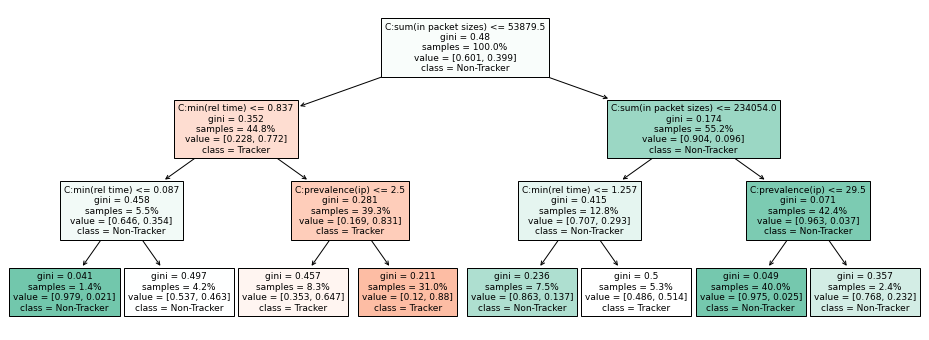

In [12]:
from sklearn import tree
from matplotlib.colors import ListedColormap, to_rgb


def visualize_tree(clf, feature_names, name, max_depth=4):
    colors = sns.color_palette("Set2")
    
    x_size = min(2.05*2**clf.get_depth(), 2*2**(max_depth+1))
    y_size = min(clf.get_depth()*2, (max_depth+1)*2)
    fig = plt.figure(figsize=(x_size,y_size))
    artists = tree.plot_tree(clf, feature_names=feature_names, filled=True, class_names=['Non-Tracker', 'Tracker'], max_depth=max_depth,
                            proportion=True, fontsize=9)

    for artist, impurity, value in zip(artists, clf.tree_.impurity, clf.tree_.value):
        # let the max value decide the color; whiten the color depending on impurity (gini)
        r, g, b = to_rgb(colors[np.argmax(value)])
        f = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
        rgb = [max(0, min(f + (1-f)*c, 1)) for c in [r, g, b]]
        artist.get_bbox_patch().set_facecolor(rgb)
        artist.get_bbox_patch().set_edgecolor('black')

    #fig.tight_layout()
    fig.savefig(ASSETS / f"{name}{CHART_FILE_EXTENSION}")

simple_dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5).fit(X_train, y_train)
visualize_tree(simple_dt, X_train.columns, f"{simple_dt}_all_features")

In [13]:
evaluate_models([simple_dt], X_test, y_test, X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
model score on training data: 0.8622636589558156
model score on testing data: 0.852824775542093
              precision    recall  f1-score   support

 Non-Tracker      0.911     0.840     0.874     47486
     Tracker      0.779     0.872     0.823     30591

    accuracy                          0.853     78077
   macro avg      0.845     0.856     0.848     78077
weighted avg      0.859     0.853     0.854     78077

[tp=26690, fp=7590, fn=3901, tn=39896



In [14]:
text_representation = tree.export_text(models[0], feature_names=list(X_train.columns), max_depth=15)
with open(ASSETS / f"{models[0]}.txt", 'w') as f:
    f.write(text_representation)

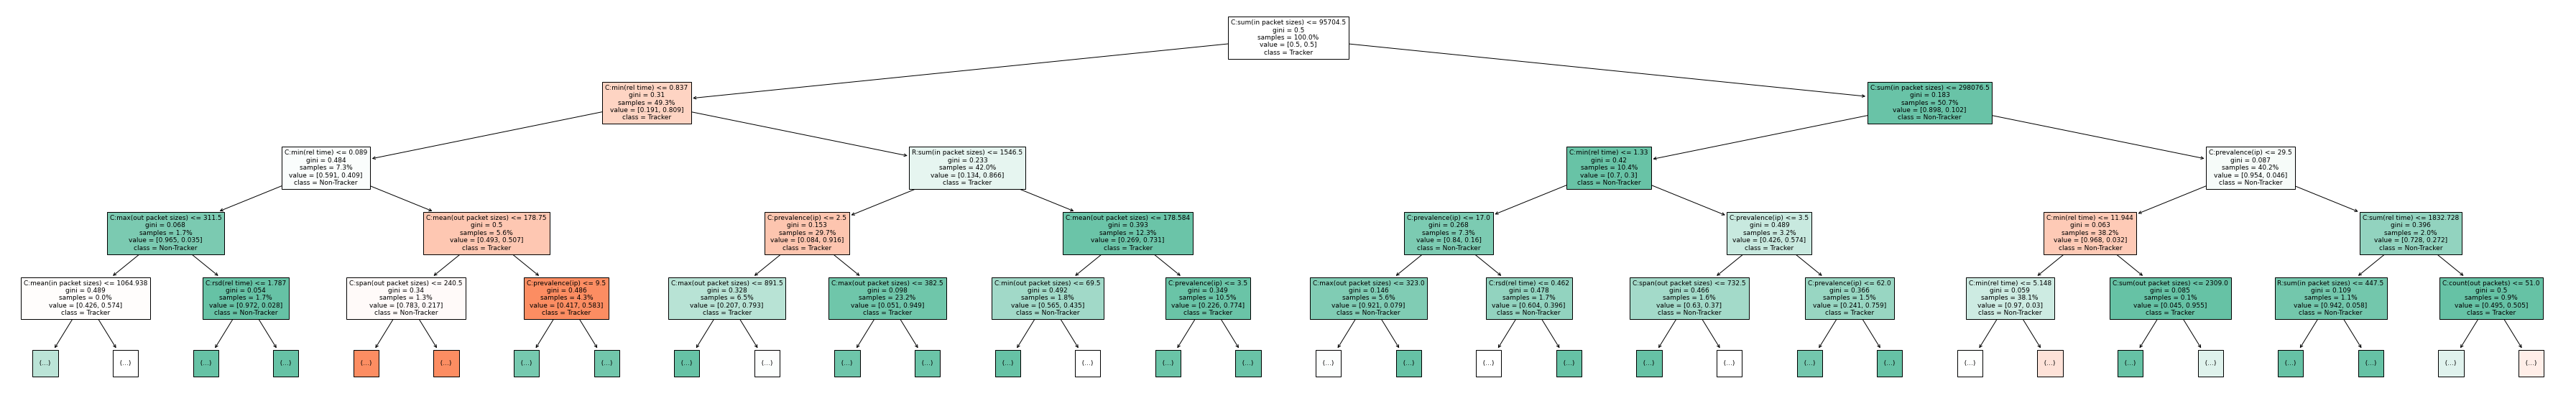

In [15]:
visualize_tree(models[0], X_train.columns, f"{models[0]}_all_features")

### Cross-Validation (split by website)

In [16]:
def undersample(df, threshold=5, attr=None):
    if attr is not None:
        df[attr] = df[attr].fillna('nan')
        attr = [attr, 'is_tracker']
    else:
        attr = 'is_tracker'
        
    gps = df.groupby(attr)
    threshold = int(gps.count()['id'].min() * threshold)
    
    return utils.shuffle(pd.concat([df.loc[gp.index] if len(gp) < threshold else gp.sample(threshold) for _, gp in gps]))
  
    
def balance_dataset(df, ratio=10, attr=None):
    if attr is not None:
        df[attr] = df[attr].fillna('nan')
        attr = [attr, 'is_tracker']
    else:
        attr = 'is_tracker'
        
    gps = df.groupby(attr)
    gps_counts = df[attr].value_counts()
    fac = gps_counts.max() / gps_counts.min() / ratio
    
    if fac <= 1:
        # dataset is already balanced (in terms of the given ratio)
        return df
    
    # oversampling
    p_oversample = 0.5 + fac / 2
    t_oversample = int(gps_counts.min() * p_oversample)
    t_undersample = int(t_oversample * ratio)
    balanced = []
    
    for name, gp in gps:
        if len(gp) < t_oversample:
            # oversample
            balanced.append(gp.sample(t_oversample, replace=True))
            
        elif len(gp) > t_undersample:
            # undersample
            balanced.append(gp.sample(t_undersample))
           
        else:
            balanced.append(df.loc[gp.index])
    
    return utils.shuffle(pd.concat(balanced))

    

def cross_validation_dataset(df, validation_size=0.1):
    rnd_websites = utils.shuffle(df['website_call'].unique().tolist())
    n_chunks = validation_size**-1
    test_website_chunks = np.array_split(rnd_websites, n_chunks)
    cross_val = []
    for test_websites in test_website_chunks:
        train = utils.shuffle(df[~df['website_call'].isin(test_websites)])
        test = utils.shuffle(df[df['website_call'].isin(test_websites)])
        cross_val.append([train, test])
    return cross_val

def cross_validate(df, X, validation_size=0.1, cols=None, balance_train=0, undersampling=0, verbose=False):
    if undersampling:
        df_len = len(df)
        df = undersample(df, undersampling)
        
        if verbose:
            print("undersample dataset")
            print(f"sample_size={len(df) / df_len:.3f}")
            print(df[[attr, 'is_tracker']].value_counts(normalize=True, sort=False))
    
    cross_val = cross_validation_dataset(df, validation_size)
    performances = {'DT': [], 'LR': []}
    W = []
    for train, test in cross_val:
        if balance_train:
            train_len = len(train)
            train = balance_dataset(train, balance)
        
            if verbose:
                print("banlance train")
                print(f"sample_size={len(train) / train_len:.3f}")
                print(f"unique samples={len(train.index.unique())}")
                print(df['is_tracker'].value_counts(normalize=True, sort=False))
        W.append(len(test))
        X_train = X.loc[train.index]
        X_test = X.loc[test.index]
        if cols is not None:
            X_train = X_train[cols]
            X_test = X_test[cols]
        y_train, y_test = train['is_tracker'], test['is_tracker']
        models = train_models(X_train, y_train)
        
        y_preds = [model.predict(X_test) for model in models]
        for name, model, y_pred in zip(['DT', 'LR'], models, y_preds):
            performances[name].append({'acc': accuracy_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred),
                                      'precision': precision_score(y_test, y_pred), 'recall': recall_score(y_test, y_pred)})
            
            
    W_sum = sum(W)     
    W = [w / W_sum for w in W]
    
    p_dt = pd.DataFrame(performances['DT']).mul(W, axis=0).sum()
    p_lr = pd.DataFrame(performances['LR']).mul(W, axis=0).sum()
    
    return performances, pd.DataFrame([p_dt, p_lr], index=['DT', 'LR'])

In [17]:
cross_val = pd.concat([cross_validate(df, X, validation_size=0.2)[1] for _ in range(5)]).groupby(level=0).mean()
cross_val.round(3)

,acc,f1,precision,recall
DT,0.899,0.875,0.852,0.900
LR,0.862,0.833,0.800,0.869


#### Difference between communication and resource features

In [18]:
def test_subfeatures(f_names):
    print(f"Only use subset of features: {f_names}")
    X_train_sub = X_train[f_names]
    X_test_sub = X_test[f_names]
    models_sub = train_models(X_train_sub, y_train)
    evaluate_models(models_sub, X_test_sub, y_test, X_train_sub, y_train)
    
    return models_sub

##### Communication features only

In [19]:
cross_val = pd.concat([cross_validate(df, X, validation_size=0.2, cols=feature_names['communication'])[1] for _ in range(5)]).groupby(level=0).mean()
cross_val.round(3)

,acc,f1,precision,recall
DT,0.882,0.860,0.815,0.910
LR,0.859,0.829,0.798,0.863


Only use subset of features: Index(['C:count(packets)', 'C:count(in packets)', 'C:count(out packets)',
       'C:sum(packet sizes)', 'C:mean(packet sizes)', 'C:rsd(packet sizes)',
       'C:min(packet sizes)', 'C:max(packet sizes)', 'C:span(packet sizes)',
       'C:sum(in packet sizes)', 'C:mean(in packet sizes)',
       'C:rsd(in packet sizes)', 'C:min(in packet sizes)',
       'C:max(in packet sizes)', 'C:span(in packet sizes)',
       'C:sum(out packet sizes)', 'C:mean(out packet sizes)',
       'C:rsd(out packet sizes)', 'C:min(out packet sizes)',
       'C:max(out packet sizes)', 'C:span(out packet sizes)',
       'C:sum(rel time)', 'C:mean(rel time)', 'C:rsd(rel time)',
       'C:min(rel time)', 'C:max(rel time)', 'C:span(rel time)',
       'C:prevalence(ip)'],
      dtype='object')
DecisionTreeClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=5)
model score on training data: 0.9059371956768147
model score on testing data: 0.8784148981134009
              precisi

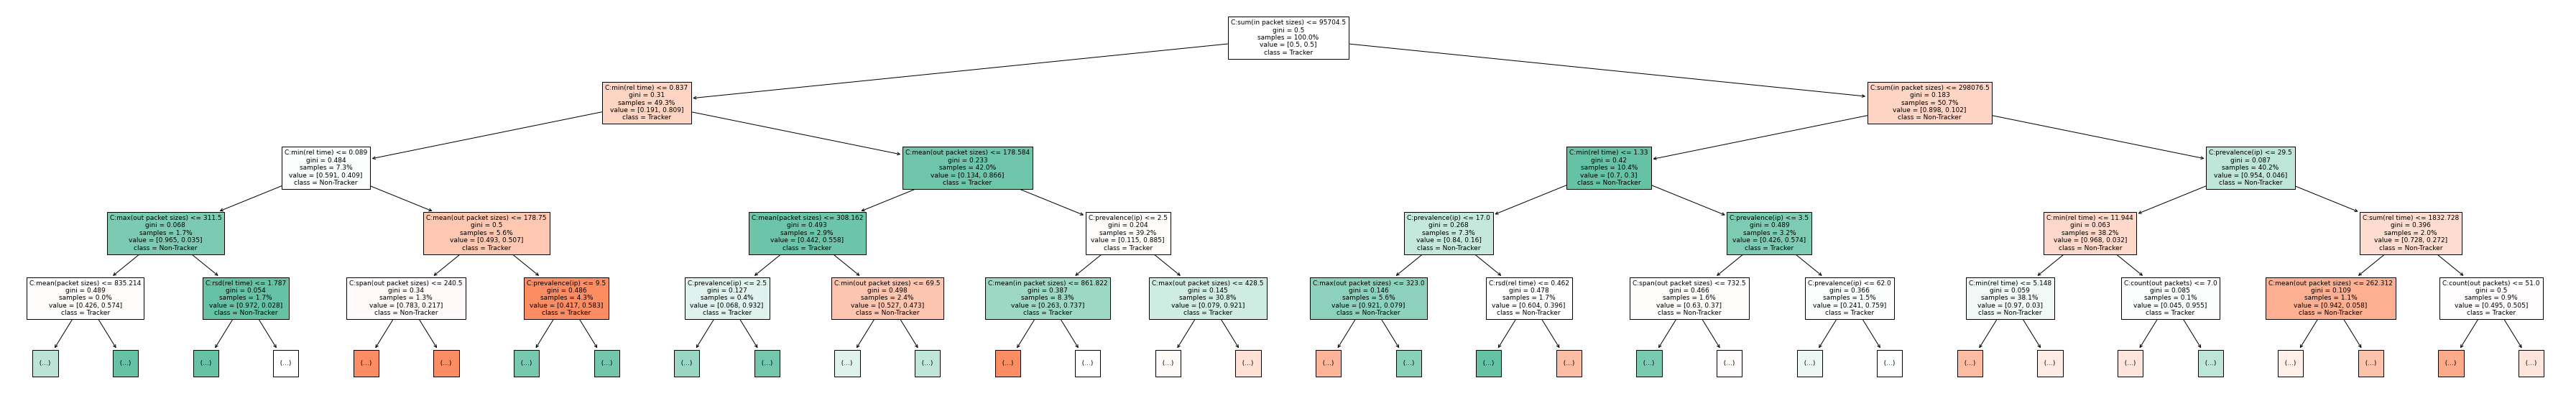

In [20]:
models_com = test_subfeatures(feature_names['communication'])
visualize_tree(models_com[0], feature_names['communication'], f"{models_com[0]}_com_features")

##### Resource features only

In [21]:
cross_val = pd.concat([cross_validate(df, X, validation_size=0.2, cols=feature_names['resource'])[1] for _ in range(5)]).groupby(level=0).mean()
cross_val.round(3)

,acc,f1,precision,recall
DT,0.853,0.824,0.780,0.873
LR,0.776,0.733,0.694,0.777


Only use subset of features: Index(['R:count(packets)', 'R:count(in packets)', 'R:count(out packets)',
       'R:sum(packet sizes)', 'R:mean(packet sizes)', 'R:rsd(packet sizes)',
       'R:min(packet sizes)', 'R:max(packet sizes)', 'R:span(packet sizes)',
       'R:sum(in packet sizes)', 'R:mean(in packet sizes)',
       'R:rsd(in packet sizes)', 'R:min(in packet sizes)',
       'R:max(in packet sizes)', 'R:span(in packet sizes)',
       'R:sum(out packet sizes)', 'R:mean(out packet sizes)',
       'R:rsd(out packet sizes)', 'R:min(out packet sizes)',
       'R:max(out packet sizes)', 'R:span(out packet sizes)',
       'R:sum(rel time)', 'R:mean(rel time)', 'R:rsd(rel time)',
       'R:min(rel time)', 'R:max(rel time)', 'R:span(rel time)',
       'R:delta resource time'],
      dtype='object')
DecisionTreeClassifier(class_weight='balanced', max_depth=7, min_samples_leaf=5)
model score on training data: 0.8633864951015608
model score on testing data: 0.854438567055599
              pre

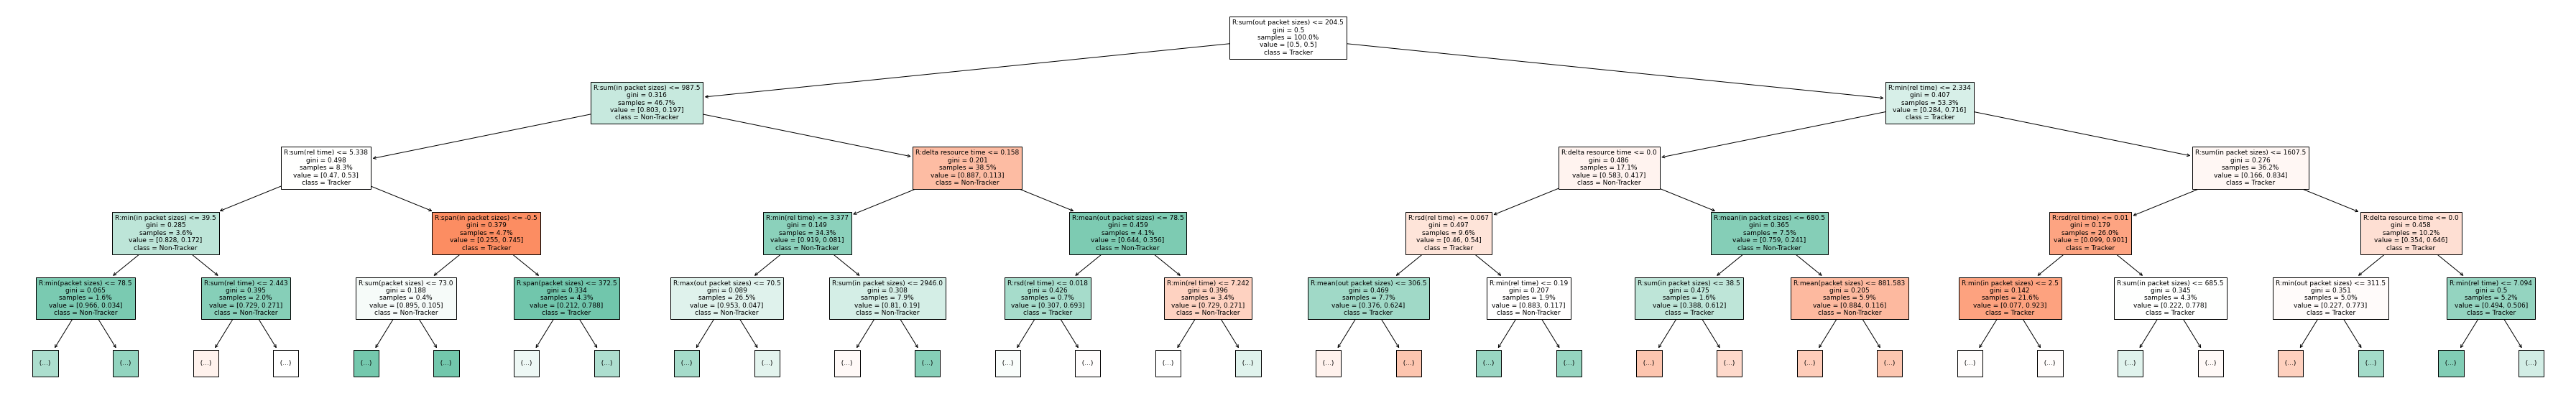

In [22]:
models_res = test_subfeatures(feature_names['resource'])
visualize_tree(models_res[0], feature_names['resource'], f"{models_res[0]}_res_features")

### Performance Tracking Type

In [23]:
# F1, Precision, Recall set to binary -> Scores only calculated for positives (how much to much detected, how well tracking detected)

def cross_validate_attribute(df, X, attr, validation_size=0.1, cols=None, only_positives=True, balance_train=0, undersampling=0, verbose=False):
    if attr not in df.columns:
        raise KeyError(attr)
        
    if undersampling:
        df_len = len(df)
        df = undersample(df, undersampling, attr)
        
        if verbose:
            print("undersample dataset")
            print(f"sample_size={len(df) / df_len:.3f}")
            print(df[[attr, 'is_tracker']].value_counts(normalize=True, sort=False))
    
    cross_val = cross_validation_dataset(df, validation_size)
    performances = {}
    support = {}
    for train, test in cross_val:
        if balance_train:
            train_len = len(train)
            train = balance_dataset(train, balance_train, attr)
        
            if verbose:
                print("balance train")
                print(f"sample_size={len(train) / train_len:.3f}")
                print(f"unique samples={len(train.index.unique()) / train_len:.3f}")
                print(train[[attr, 'is_tracker']].value_counts(normalize=True, sort=False))
            
        X_train = X.loc[train.index]
        X_test = X.loc[test.index]
        if cols is not None:
            X_train = X_train[cols]
            X_test = X_test[cols]
        y_train, y_test = train['is_tracker'], test['is_tracker']
        models = train_models(X_train, y_train)
        
        test[attr] = test[attr].fillna('nan')
        for type_name, gp in test.groupby(attr):            
            X_test_type = X_test.loc[gp.index]
            y_test_type = y_test.loc[gp.index]
            if type_name not in performances:    
                performances[type_name] = {'DT': [], 'LR': []}
            if type_name not in support:
                support[type_name] = []
                
            support[type_name].append(pd.concat([pd.Series([len(gp)], index=['total']), 
                                                 gp['is_tracker'].value_counts(sort=False)]))
            y_preds = [model.predict(X_test_type) for model in models]
            
            for model_name, y_pred in zip(['DT', 'LR'], y_preds):
                performance = {'acc': accuracy_score(y_test_type, y_pred)}
                performance['f1_F'], performance['f1_T'] = f1_score(y_test_type, y_pred, average=None, zero_division=1)
                performance['precision_F'], performance['precision_T'] = precision_score(y_test_type, y_pred, average=None, zero_division=1)
                performance['recall_F'], performance['recall_T'] = recall_score(y_test_type, y_pred, average=None, zero_division=1)
                
                performances[type_name][model_name].append(performance)
            
            
    support = {k: pd.DataFrame(s) for k, s in support.items()}
    rename = {'total': 'acc', False: 'f1_F', True: 'f1_T'}
    W = {attr_name: (n_samples / n_samples.sum()).rename(columns=rename) for attr_name, n_samples in support.items()}
    for df_m in W.values():
        df_m['precision_F'] = df_m['f1_F']
        df_m['precision_T'] = df_m['f1_T']
        df_m['recall_F'] = df_m['f1_F']
        df_m['recall_T'] = df_m['f1_T']
    
    df_type = {k: {model: pd.DataFrame(df_m).mul(W[k]).sum() for model, df_m in v.items()} for k, v in performances.items()}         
    df_type = {k: pd.DataFrame(v) for k, v in df_type.items()}
    
    if only_positives:
        for df_m in df_type.values():
            idx = [i for i in df_m.index if '_F' in i]
            df_m.drop(idx, inplace=True)
    
    return df_type

In [24]:
from IPython.display import display_html

def mydisplay(dfs, names=[], index=True, precision=3):
    def to_df(x):
        if isinstance(x, pd.Series):
            return pd.DataFrame(x)
        else:
            return x
    html_str = ''
    if names:
        html_str += ('<tr>' + 
                     ''.join(f'<td style="text-align:center">{name}</td>' for name in names) + 
                     '</tr>')
    html_str += ('<tr>' + 
                 ''.join(f'<td style="vertical-align:top"> {to_df(df.round(precision)).to_html(index=index)}</td>' 
                         for df in dfs) + 
                 '</tr>')
    html_str = f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

#### All model

In [25]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'type', validation_size=0.2, undersampling=225, verbose=True) for _ in range(10)])
cross_val = {col: pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

undersample dataset
sample_size=0.307
type        is_tracker
document    False         0.082676
            True          0.082676
font        False         0.078169
            True          0.000367
image       False         0.082676
            True          0.082676
media       False         0.009137
            True          0.000674
nan         False         0.082676
            True          0.082676
other       False         0.082676
            True          0.082676
script      False         0.082676
            True          0.082676
stylesheet  False         0.082676
            True          0.002217
dtype: float64
undersample dataset
sample_size=0.307
type        is_tracker
document    False         0.082676
            True          0.082676
font        False         0.078169
            True          0.000367
image       False         0.082676
            True          0.082676
media       False         0.009137
            True          0.000674
nan         False      

document font image media nan other script stylesheet 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.888 
 0.788 
 
 
 f1_T 
 0.893 
 0.805 
 
 
 precision_T 
 0.855 
 0.747 
 
 
 recall_T 
 0.935 
 0.873 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.957 
 0.960 
 
 
 f1_T 
 0.072 
 0.098 
 
 
 precision_T 
 0.046 
 0.060 
 
 
 recall_T 
 0.267 
 0.333 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.920 
 0.911 
 
 
 f1_T 
 0.918 
 0.907 
 
 
 precision_T 
 0.941 
 0.951 
 
 
 recall_T 
 0.897 
 0.867 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.836 
 0.770 
 
 
 f1_T 
 0.477 
 0.182 
 
 
 precision_T 
 0.385 
 0.144 
 
 
 recall_T 
 0.785 
 0.329 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.872 
 0.821 
 
 
 f1_T 
 0.879 
 0.839 
 
 
 precision_T 
 0.839 
 0.766 
 
 
 recall_T 
 0.924 
 0.928 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.829 
 0.763 
 
 
 f1_T 
 0.836 
 0.777 
 
 
 precision_T 
 0.801 
 0.735 
 
 
 recall_T 
 0.877 
 0.824 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.841 
 0.660 
 
 
 f1_T 
 0.835 
 0.528 
 
 
 precision_T 
 0.867 
 0.864 
 
 
 recall_T 
 0.805 
 0.381 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.935 
 0.932 
 
 
 f1_T 
 0.317 
 0.174 
 
 
 precision_T 
 0.232 
 0.132 
 
 
 recall_T 
 0.532 
 0.271

#### Resource model

In [26]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'type', validation_size=0.2, cols=feature_names['resource'], undersampling=225) for _ in range(10)])
cross_val = {col: pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

document font image media nan other script stylesheet 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.802 
 0.761 
 
 
 f1_T 
 0.822 
 0.760 
 
 
 precision_T 
 0.749 
 0.765 
 
 
 recall_T 
 0.913 
 0.755 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.958 
 0.927 
 
 
 f1_T 
 0.083 
 0.078 
 
 
 precision_T 
 0.052 
 0.044 
 
 
 recall_T 
 0.300 
 0.467 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.917 
 0.768 
 
 
 f1_T 
 0.918 
 0.755 
 
 
 precision_T 
 0.911 
 0.799 
 
 
 recall_T 
 0.925 
 0.716 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.615 
 0.492 
 
 
 f1_T 
 0.127 
 0.275 
 
 
 precision_T 
 0.101 
 0.178 
 
 
 recall_T 
 0.267 
 0.791 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.826 
 0.732 
 
 
 f1_T 
 0.845 
 0.744 
 
 
 precision_T 
 0.768 
 0.716 
 
 
 recall_T 
 0.942 
 0.777 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.745 
 0.627 
 
 
 f1_T 
 0.778 
 0.610 
 
 
 precision_T 
 0.692 
 0.643 
 
 
 recall_T 
 0.890 
 0.583 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.771 
 0.607 
 
 
 f1_T 
 0.752 
 0.469 
 
 
 precision_T 
 0.819 
 0.722 
 
 
 recall_T 
 0.696 
 0.348 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.904 
 0.914 
 
 
 f1_T 
 0.163 
 0.206 
 
 
 precision_T 
 0.109 
 0.142 
 
 
 recall_T 
 0.344 
 0.403

#### Communication model

In [27]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'type', validation_size=0.2, cols=feature_names['communication'], undersampling=225) for _ in range(10)])
cross_val = {col: pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

document font image media nan other script stylesheet 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.867 
 0.788 
 
 
 f1_T 
 0.876 
 0.805 
 
 
 precision_T 
 0.825 
 0.748 
 
 
 recall_T 
 0.934 
 0.872 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.955 
 0.960 
 
 
 f1_T 
 0.054 
 0.093 
 
 
 precision_T 
 0.033 
 0.056 
 
 
 recall_T 
 0.193 
 0.333 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.924 
 0.912 
 
 
 f1_T 
 0.922 
 0.908 
 
 
 precision_T 
 0.945 
 0.953 
 
 
 recall_T 
 0.901 
 0.867 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.815 
 0.766 
 
 
 f1_T 
 0.459 
 0.182 
 
 
 precision_T 
 0.357 
 0.153 
 
 
 recall_T 
 0.800 
 0.333 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.858 
 0.820 
 
 
 f1_T 
 0.868 
 0.838 
 
 
 precision_T 
 0.812 
 0.766 
 
 
 recall_T 
 0.933 
 0.927 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.799 
 0.763 
 
 
 f1_T 
 0.814 
 0.777 
 
 
 precision_T 
 0.758 
 0.735 
 
 
 recall_T 
 0.881 
 0.825 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.823 
 0.657 
 
 
 f1_T 
 0.815 
 0.523 
 
 
 precision_T 
 0.855 
 0.859 
 
 
 recall_T 
 0.780 
 0.377 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.933 
 0.932 
 
 
 f1_T 
 0.270 
 0.174 
 
 
 precision_T 
 0.199 
 0.130 
 
 
 recall_T 
 0.447 
 0.270

### Performance FP vs. TP

#### All model

In [28]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'is_tp', validation_size=0.2, undersampling=4.5, verbose=True) for _ in range(10)])
cross_val = {'third_party' if col else 'first_party': pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

undersample dataset
sample_size=0.309
is_tp  is_tracker
False  False         0.310344
       True          0.068967
True   False         0.310344
       True          0.310344
dtype: float64
undersample dataset
sample_size=0.309
is_tp  is_tracker
False  False         0.310344
       True          0.068967
True   False         0.310344
       True          0.310344
dtype: float64
undersample dataset
sample_size=0.309
is_tp  is_tracker
False  False         0.310344
       True          0.068967
True   False         0.310344
       True          0.310344
dtype: float64
undersample dataset
sample_size=0.309
is_tp  is_tracker
False  False         0.310344
       True          0.068967
True   False         0.310344
       True          0.310344
dtype: float64
undersample dataset
sample_size=0.309
is_tp  is_tracker
False  False         0.310344
       True          0.068967
True   False         0.310344
       True          0.310344
dtype: float64
undersample dataset
sample_size=0.309
is_tp  

first_party third_party 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.878 
 0.888 
 
 
 f1_T 
 0.663 
 0.672 
 
 
 precision_T 
 0.668 
 0.713 
 
 
 recall_T 
 0.661 
 0.639 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.873 
 0.804 
 
 
 f1_T 
 0.877 
 0.798 
 
 
 precision_T 
 0.850 
 0.822 
 
 
 recall_T 
 0.906 
 0.775

#### Resource model

In [29]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'is_tp', validation_size=0.2, cols=feature_names['resource'], undersampling=4.5) for _ in range(10)])
cross_val = {'third_party' if col else 'first_party': pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

first_party third_party 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.863 
 0.794 
 
 
 f1_T 
 0.675 
 0.571 
 
 
 precision_T 
 0.595 
 0.464 
 
 
 recall_T 
 0.782 
 0.745 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.832 
 0.762 
 
 
 f1_T 
 0.840 
 0.759 
 
 
 precision_T 
 0.802 
 0.768 
 
 
 recall_T 
 0.882 
 0.752

#### Communiation model

In [30]:
cross_val = pd.DataFrame([cross_validate_attribute(df, X, 'is_tp', validation_size=0.2, cols=feature_names['communication'], undersampling=4.5) for _ in range(10)])
cross_val = {'third_party' if col else 'first_party': pd.concat(cross_val[col].tolist()).groupby(level=0).mean() for col in cross_val.columns}
mydisplay(cross_val.values(), cross_val.keys())

first_party third_party 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.883 
 0.888 
 
 
 f1_T 
 0.670 
 0.673 
 
 
 precision_T 
 0.688 
 0.715 
 
 
 recall_T 
 0.657 
 0.638 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.854 
 0.804 
 
 
 f1_T 
 0.864 
 0.798 
 
 
 precision_T 
 0.811 
 0.823 
 
 
 recall_T 
 0.926 
 0.775

### Difference between http and http2

In [31]:
cross_val = cross_validate_attribute(df, X, 'protocol', validation_size=0.2)
mydisplay(cross_val.values(), cross_val.keys())

http http2 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.911 
 0.872 
 
 
 f1_T 
 0.930 
 0.906 
 
 
 precision_T 
 0.908 
 0.840 
 
 
 recall_T 
 0.955 
 0.983 
 
 
 
 
 
 
 DT 
 LR 
 
 
 
 
 acc 
 0.900 
 0.860 
 
 
 f1_T 
 0.863 
 0.809 
 
 
 precision_T 
 0.840 
 0.787 
 
 
 recall_T 
 0.887 
 0.832

In [32]:
for protocol in ['http', 'http2']:
    print(protocol)
    X_test_protocol = X_test.loc[df['protocol'] == protocol]
    y_test_protocol = y_test.loc[df['protocol'] == protocol]
    for model in models:
        print(model)
        predictions = model.predict(X_test_protocol)
        print(classification_report(y_test_protocol, predictions, target_names=['Non-Tracker', 'Tracker']))
        tn, fp, fn, tp = confusion_matrix(y_test_protocol, predictions).ravel()
        print(f"[tp={tp}, fp={fp}, fn={fn}, tn={tn}\n")


http
DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5)
              precision    recall  f1-score   support

 Non-Tracker       0.88      0.85      0.86      4640
     Tracker       0.91      0.93      0.92      7572

    accuracy                           0.90     12212
   macro avg       0.89      0.89      0.89     12212
weighted avg       0.90      0.90      0.90     12212

[tp=7011, fp=705, fn=561, tn=3935

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))])
              precision    recall  f1-score   support

 Non-Tracker       0.95      0.71      0.81      4640
     Tracker       0.85      0.98      0.91      7572

    accuracy                           0.88     12212
   macro avg       0.90      0.84      0.86     12212
weighted avg       

### Look at the data

#### Threshold 0.5

In [33]:
def look_at_data(models, X_test, y_test, K=5, threshold=.5):
    predictions = []
    for model in models:
        print(f"== {model} ==")
        prediction = np.apply_along_axis(lambda x: True if x[1] >= threshold else False, axis=1, arr=model.predict_proba(X_test))
        predictions.append(prediction)
        result = pd.concat([pd.DataFrame({'true': y_test, 'prediction': prediction}), df.loc[X_test.index][['url', 'website_call']], X_test], axis=1)
        print("True Positive:")
        display(result[(result['true'] & result['prediction'])][result.columns[2:]].head(K))
        print("\nTrue Negative:")
        display(result[(~result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
        print("\nFalse Positive:")
        display(result[(~result['true'] & result['prediction'])][result.columns[2:]].head(K))
        print("\nFalse Negative:")
        display(result[(result['true'] & ~result['prediction'])][result.columns[2:]].head(K))
        print()
    return predictions
        
predictions = look_at_data(models, X_test, y_test, K=5, threshold=0.5)

== DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5) ==
True Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
122202,https://x.bidswitch.net/sync?ssp=adform,timeout.com,22,11,11,15292,695.091,0.397,254,1291,1037,6046.0,549.636,0.477,254.0,1291.0,1037.0,9246,840.545,0.241,616,1148,532,242.993,11.045,0.184,7.347,13.005,5.658,3.0,2,1,1,1034,517.0,0.191,418,616,198,418.0,418.0,0.000,418.0,418.0,0.0,616.0,616.0,0.000,616.0,616.0,0.0,24.086,12.043,0.001,12.036,12.050,0.014,0.114819
87000,https://sync-tm.everesttech.net/upi/pid/eknnbrON?gdpr=1&gdpr_consent=CPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA&redir=https%3A%2F%2Fups.analytics.yahoo.com%2Fups%2F55986%2Fsync%3Fuid%3D%24%7BUSER_ID%7D%26_origin%3D0%26gdpr%3D1%26gdpr_consent%3DCPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA,msn.com,14,6,8,11151,796.500,0.734,183,1460,1277,4258.0,709.667,0.770,183.0,1460.0,1277.0,6893,861.625,0.701,185,1460,1275,101.346,7.239,0.016,7.027,7.375,0.348,77.0,4,2,2,3494,873.5,0.676,185,1460,1275,1849.0,924.5,0.579,389.0,1460.0,1071.0,1645.0,822.5,0.775,185.0,1460.0,1275.0,29.113,7.278,0.007,7.227,7.330,0.103,0.199857
46917,https://um.simpli.fi/pm_match?https://dsum-sec.casalemedia.com/crum?cm_dsp_id=90&ext


True Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
131501,https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1407058591.jpg,gettyimages.com,911,853,58,1240672,1361.879,0.251,12,1460,1448,1234726.0,1447.510,0.066,12.0,1460.0,1448.0,5946,102.517,0.355,97,377,280,1292.594,1.419,0.029,1.334,1.477,0.143,1.0,1,0,1,98,98.000,0.000,98,98,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,98.0,98.0,0.0,98.0,98.0,0.0,1.434,1.434,0.000,1.434,1.434,0.000,0.000291
118515,https://consent.trustarc.com/asset/trustarc_cookiepreferences.png,ihg.com,219,211,8,291475,1330.936,0.239,74,1460,1386,290182.0,1375.270,0.164,117.0,1460.0,1343.0,1293,161.625,0.675,74,371,297,1515.955,6.922,0.047,6.038,7.060,1.022,3.0,3,2,1,2525,841.667,0.681,78,1460,1382,2447.0,1223.500,0.193,987.0,1460.0,473.0,78.0,78.0,0.0,78.0,78.0,0.0,18.346,6.115,0.002,6.099,6.124,0.025,0.061244
143822,https://www.apple.com/metrics/ac-analytics/2.15.1/scripts/ac-analytics.js,apple.com,1052,1009,43,1441829,1370.560,0.224,78,1460,1382,1436336.0,1423.524,0.121,78.0,1460.0,1382.0,5493,127.744,0.421,78,349,271,588.021,0.559,0.457,0.084,1.116,1.032,1.0,66,65,1,92964,1408.545,0.146,89,1460,1371,92875.0,1428.846,0.088,782.0,1460.0,678.0,89.0,89.0,0.0,89.0,89.0,0.0,16.566,0.251,0.063,0.130,0.262,0.132,0.000060
61317,https://g.alicdn.com/alilog/s/8.15.21/plugin/aplus_ae.js,wanwang.aliyun.com,620,570,50,817882,1319.165,0.301,44,1460,1416,812512.0,1425.460,0.125,44.0,1460.0,1416.0,5370,107.400,0.649,70,434,364,1692.833,2.730,0.746,0.260,8.480,8.220,2.0,1,0,1,78,78.000,0.000,78,78,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,78.0,78.0,0.0,78.0,78.0,0.0,5.265,5.265,0.000,5.265,5.265,0.000,0.044148
153275,https://www.intel.com/etc.clientlibs/settings/wcm/designs/ver/221031/intel/clientlibs/pages/secondaryNav.min.css,intel.com,1406,1328,78,1897565,1349.619,0.246,1,1460,1459,1866525.0,1405.516,0.156,1.0,1460.0,1459.0,31040,397.949,1.152,87,1460,1373,2039.715,1.451,0.669,0.209,3.712,3.503,-1.0,9,8,1,11694,1299.333,0.320,125,1460,1335,11569.0,1446.125,0.014,1400.0,1460.0,60.0,125.0,125.0,0.0,125.0,125.0,0.0,3.284,0.365,0.112,0.249,0.380,0.131,0.000079



False Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
241481,"https://img.mlbstatic.com/mlb-images/image/upload/w_240,h_382,g_auto,c_fill,q_auto:best/mlb/chqwgph7dgm6tt0tatfz",mlb.com,62,52,10,75653,1220.210,0.403,116,1460,1344,73933.0,1421.788,0.129,183.0,1460.0,1277.0,1720,172.000,0.649,116,416,300,536.921,8.660,0.366,0.942,9.980,9.038,-1.0,1,0,1,116,116.00,0.000,116,116,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,116.0,116.0,0.0,116.0,116.0,0.0,0.962,0.962,0.000,0.962,0.962,0.000,0.000559
197600,https://storage.googleapis.com/workbox-cdn/releases/3.0.0/workbox-core.prod.js,forbes.com,8,6,2,7873,984.125,0.541,85,1460,1375,7502.0,1250.333,0.242,728.0,1460.0,732.0,371,185.500,0.542,85,286,201,30.457,3.807,0.005,3.783,3.827,0.044,1.0,4,3,1,3939,984.75,0.571,85,1460,1375,3854.0,1284.667,0.193,934.0,1460.0,526.0,85.0,85.0,0.0,85.0,85.0,0.0,15.296,3.824,0.001,3.817,3.827,0.010,0.033727
257280,https://assets.tumblr.com/pop/src/assets/images/login-wall/art_v2-004010f0.webm,tumblr.com,258,235,23,336349,1303.678,0.286,72,1460,1388,322887.0,1373.987,0.189,131.0,1460.0,1329.0,13462,585.304,0.931,72,1460,1388,631.359,2.447,0.660,0.000,7.161,7.161,-1.0,1,0,1,128,128.00,0.000,128,128,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,128.0,128.0,0.0,128.0,128.0,0.0,4.335,4.335,0.000,4.335,4.335,0.000,0.038761
135939,https://t.myvisualiq.net/sync?prid=AMZNPNR1&ao=0&red=https%3A%2F%2Fs.amazon-adsystem.com%2Fecm3%3Fex%3Dvisualiq%26id%3D%24%7BUUID%7D,miamiherald.com,4,2,2,2657,664.250,0.084,588,742,154,1388.0,694.000,0.069,646.0,742.0,96.0,1269,634.500,0.073,588,681,93,57.199,14.300,0.005,14.230,14.369,0.139,5.0,2,1,1,1330,665.00,0.116,588,742,154,742.0,742.000,0.000,742.0,742.0,0.0,588.0,588.0,0.0,588.0,588.0,0.0,28.469,14.234,0.000,14.230,14.238,0.008,0.000000
42797,https://static.scroll.com/js/scroll.js,reuters.com,4,3,1,2870,717.500,0.615,297,1460,1163,2573.0,857.667,0.497,554.0,1460.0,906.0,297,297.000,0.000,297,297,0,2.761,0.690,0.006,0.683,0.693,0.010,51.0,4,3,1,2870,717.50,0.615,297,1460,1163,2573.0,857.667,0.497,554.0,1460.0,906.0,297.0,297.0,0.0,297.0,297.0,0.0,2.761,0.690,0.006,0.683,0.693,0.010,0.000000



False Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
181685,https://ice.360yield.com/hb?jsonp=%7B%22bid_request%22%3A%7B%22id%22%3A%22K2LE5b0q%22%2C%22callback%22%3A%22window.headertag.ImproveDigitalHtb.adResponseCallback%22%2C%22secure%22%3A1%2C%22version%22%3A%22IX-2.1.1-JS-5.1.1%22%2C%22gdpr%22%3A%22CPiLUcAPiLUcAAKAoADECpCsAP_AAH_AAAwIJHtd_H__bW9r-f5_aft0eY1P9_r37uQzDhfNk-8F3L_W_LwX52E7NF36tq4KmR4ku1LBIUNlHMHUDUmwaokVryHsak2cpzNKJ7BEknMZOydYGF9vmxtj-QKY7_5_d3bx2D-t_9v239z3z81Xn3d53-_03LCdV5_9Dfn9fR_b89KP9_78v4v8_____3_e__3_7997-CRoBJhq3EAXZljgzaBhFAiBGFYSFUCgAgoBhaIDABwcFOysAn1hAgAQCgCMCIEOAKMCAQAACQBIRABIEWCAAAEQCAAEACIRCABgYBBYAWBgEAAIBoGKIUAAgSEGRARFKYEBUCQQGtlQglBdIaYQBVlgBQSI2KgARBICKwABAWDgGCJASsWCBJijfIARghQCiVCtRCAA.f_gAAAAAAAAA%22%2C%22imp%22%3A%5B%7B%22id%22%3A%22_3gEsKdUF%22%2C%22pid%22%3A22446427%2C%22banner%22%3A%7B%7D%7D%5D%7D%7D,techradar.com,12,6,6,11371,947.583,0.294,656,1460,804,7155.0,1192.500,0.131,924.0,1460.0,536.0,4216,702.667,0.148,656,935,279,32.187,2.682,0.009,2.659,2.721,0.062,1.0,2,1,1,2116,1058.00,0.380,656,1460,804,1460.0,1460.0,0.0,1460.0,1460.0,0.0,656.0,656.0,0.000,656.0,656.0,0.0,5.361,2.681,0.008,2.660,2.702,0.042,0.000680
114241,"https://rs.mail.ru/ns.gif?n=374383327,374383325,374383337,374383345,374383305,374383341,374383303,374383343&_=1668772383686",ok.ru,54,28,26,19814,366.926,1.159,74,1460,1386,15317.0,547.036,0.939,152.0,1460.0,1308.0,4497,172.962,0.792,74,588,514,150.553,2.788,0.455,0.806,4.159,3.353,2.0,2,1,1,483,241.50,0.400,145,338,193,338.0,338.0,0.0,338.0,338.0,0.0,145.0,145.0,0.000,145.0,145.0,0.0,3.529,1.764,0.014,1.739,1.790,0.051,0.001366
175013,https://api.segment.io/v1/t,typeform.com,47,9,38,25054,533.064,1.107,38,1460,1422,3249.0,361.000,0.848,38.0,1160.0,1122.0,21805,573.816,1.102,66,1460,1394,209.453,4.456,0.029,4.396,4.772,0.376,1.0,4,1,3,2105,526.25,1.065,70,1460,1390,464.0,464.0,0.0,464.0,464.0,0.0,1641.0,547.0,1.181,70.0,1460.0,1390.0,17.774,4.443,0.018,4.396,4.585,0.189,0.000053
10537,https://pl.connatix.com/,accuweather.com,422,399,23,559080,1324.834,0.288,11,1460,1449,554375.0,1389.411,0.198,11.0,1460.0,1449.0,4705,204.565,0.848,58,829,771,1169.519,2.771,0.462,1.491,4.877,3.386,80.0,3,1,2,1419,473.00,0.536,258,829,571,258.0,258.0,0.0,258.0,258.0,0.0,1161.0,580.5,0.428,332.0,829.0,497.0,11.227,3.742,0.046,3.620,3.987,0.367,0.042468
172198,https://ly-bit-prod1.collector.snplow.net/com.snowplowanalytics.snowplow/tp2,bitly.com,2,1,1,604,302.000,0.182,247,357,110,247.0,247.000,0.000,247.0,247.0,0.0,357,357.000,0.000,357,357,0,4.163,2.081,0.024,2.032,2.131,0.099,-1.0,2,1,1,604,302.00,0.182,247,357,110,247.0,247.0,0.0,247.0,247.0,0.0,357.0,357.0,0.000,357.0,357.0,0.0,4.163,2.081,0.024,2.032,2.131,0.099,0.000000



== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))]) ==
True Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
122202,https://x.bidswitch.net/sync?ssp=adform,timeout.com,22,11,11,15292,695.091,0.397,254,1291,1037,6046.0,549.636,0.477,254.0,1291.0,1037.0,9246,840.545,0.241,616,1148,532,242.993,11.045,0.184,7.347,13.005,5.658,3.0,2,1,1,1034,517.0,0.191,418,616,198,418.0,418.0,0.000,418.0,418.0,0.0,616.0,616.0,0.000,616.0,616.0,0.0,24.086,12.043,0.001,12.036,12.050,0.014,0.114819
87000,https://sync-tm.everesttech.net/upi/pid/eknnbrON?gdpr=1&gdpr_consent=CPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA&redir=https%3A%2F%2Fups.analytics.yahoo.com%2Fups%2F55986%2Fsync%3Fuid%3D%24%7BUSER_ID%7D%26_origin%3D0%26gdpr%3D1%26gdpr_consent%3DCPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA,msn.com,14,6,8,11151,796.500,0.734,183,1460,1277,4258.0,709.667,0.770,183.0,1460.0,1277.0,6893,861.625,0.701,185,1460,1275,101.346,7.239,0.016,7.027,7.375,0.348,77.0,4,2,2,3494,873.5,0.676,185,1460,1275,1849.0,924.5,0.579,389.0,1460.0,1071.0,1645.0,822.5,0.775,185.0,1460.0,1275.0,29.113,7.278,0.007,7.227,7.330,0.103,0.199857
46917,https://um.simpli.fi/pm_match?https://dsum-sec.casalemedia.com/crum?cm_dsp_id=90&ext


True Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
131501,https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1407058591.jpg,gettyimages.com,911,853,58,1240672,1361.879,0.251,12,1460,1448,1234726.0,1447.510,0.066,12.0,1460.0,1448.0,5946,102.517,0.355,97,377,280,1292.594,1.419,0.029,1.334,1.477,0.143,1.0,1,0,1,98,98.000,0.000,98,98,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,98.0,98.0,0.0,98.0,98.0,0.0,1.434,1.434,0.000,1.434,1.434,0.000,0.000291
118515,https://consent.trustarc.com/asset/trustarc_cookiepreferences.png,ihg.com,219,211,8,291475,1330.936,0.239,74,1460,1386,290182.0,1375.270,0.164,117.0,1460.0,1343.0,1293,161.625,0.675,74,371,297,1515.955,6.922,0.047,6.038,7.060,1.022,3.0,3,2,1,2525,841.667,0.681,78,1460,1382,2447.0,1223.500,0.193,987.0,1460.0,473.0,78.0,78.0,0.0,78.0,78.0,0.0,18.346,6.115,0.002,6.099,6.124,0.025,0.061244
143822,https://www.apple.com/metrics/ac-analytics/2.15.1/scripts/ac-analytics.js,apple.com,1052,1009,43,1441829,1370.560,0.224,78,1460,1382,1436336.0,1423.524,0.121,78.0,1460.0,1382.0,5493,127.744,0.421,78,349,271,588.021,0.559,0.457,0.084,1.116,1.032,1.0,66,65,1,92964,1408.545,0.146,89,1460,1371,92875.0,1428.846,0.088,782.0,1460.0,678.0,89.0,89.0,0.0,89.0,89.0,0.0,16.566,0.251,0.063,0.130,0.262,0.132,0.000060
61317,https://g.alicdn.com/alilog/s/8.15.21/plugin/aplus_ae.js,wanwang.aliyun.com,620,570,50,817882,1319.165,0.301,44,1460,1416,812512.0,1425.460,0.125,44.0,1460.0,1416.0,5370,107.400,0.649,70,434,364,1692.833,2.730,0.746,0.260,8.480,8.220,2.0,1,0,1,78,78.000,0.000,78,78,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,78.0,78.0,0.0,78.0,78.0,0.0,5.265,5.265,0.000,5.265,5.265,0.000,0.044148
153275,https://www.intel.com/etc.clientlibs/settings/wcm/designs/ver/221031/intel/clientlibs/pages/secondaryNav.min.css,intel.com,1406,1328,78,1897565,1349.619,0.246,1,1460,1459,1866525.0,1405.516,0.156,1.0,1460.0,1459.0,31040,397.949,1.152,87,1460,1373,2039.715,1.451,0.669,0.209,3.712,3.503,-1.0,9,8,1,11694,1299.333,0.320,125,1460,1335,11569.0,1446.125,0.014,1400.0,1460.0,60.0,125.0,125.0,0.0,125.0,125.0,0.0,3.284,0.365,0.112,0.249,0.380,0.131,0.000079



False Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
132033,https://cdn.jsdelivr.net/gh/prebid/currency-file@1/latest.json?date=20221109,globo.com,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.50,0.750,209.0,1460.0,1251.0,348,348.000,0.000,348,348,0,10.276,3.425,0.006,3.398,3.439,0.041,9.0,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.500,0.750,209.0,1460.0,1251.0,348.0,348.0,0.0,348.0,348.0,0.0,10.276,3.425,0.006,3.398,3.439,0.041,0.000000
75034,https://privacyportal.onetrust.com/request/v1/consentreceipts,zendesk.com,11,3,8,10388,944.364,0.624,75,1460,1385,1827.0,609.00,0.999,75.0,1460.0,1385.0,8561,1070.125,0.495,129,1460,1331,55.853,5.078,0.019,4.879,5.251,0.372,74.0,2,1,1,647,323.500,0.097,292,355,63,292.0,292.000,0.000,292.0,292.0,0.0,355.0,355.0,0.0,355.0,355.0,0.0,9.930,4.965,0.017,4.879,5.050,0.171,0.000000
94954,https://c.evidon.com/sitenotice/1975/snthemes.js,lenovo.com,55,46,9,64148,1166.327,0.436,70,1460,1390,63152.0,1372.87,0.160,363.0,1460.0,1097.0,996,110.667,0.645,70,308,238,290.428,5.281,0.009,5.226,5.363,0.137,10.0,7,6,1,8568,1224.000,0.387,79,1460,1381,8489.0,1414.833,0.060,1225.0,1460.0,235.0,79.0,79.0,0.0,79.0,79.0,0.0,36.663,5.238,0.001,5.226,5.240,0.014,0.000061
4336,https://fonts.googleapis.com/css2?family=Montserrat:wght@300;400;500;600;700&display=swap,heart.org,3,2,1,2065,688.333,0.721,337,1390,1053,1727.0,863.50,0.610,337.0,1390.0,1053.0,338,338.000,0.000,338,338,0,6.820,2.273,0.003,2.263,2.279,0.016,184.0,3,2,1,2065,688.333,0.721,337,1390,1053,1727.0,863.500,0.610,337.0,1390.0,1053.0,338.0,338.0,0.0,338.0,338.0,0.0,6.820,2.273,0.003,2.263,2.279,0.016,0.000000
24778,https://565ef00beeef741806748404af64227e.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html,globo.com,4,3,1,4090,1022.500,0.443,418,1460,1042,3672.0,1224.00,0.273,752.0,1460.0,708.0,418,418.000,0.000,418,418,0,33.104,8.276,0.001,8.264,8.280,0.016,124.0,4,3,1,4090,1022.500,0.443,418,1460,1042,3672.0,1224.000,0.273,752.0,1460.0,708.0,418.0,418.0,0.0,418.0,418.0,0.0,33.104,8.276,0.001,8.264,8.280,0.016,0.000000



False Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
8444,https://px.moatads.com/pixel.gif?e=37&q=0&hp=1&zMoatGNID=7175&zMoatAU1=fdc.forbes&zMoatAU2=home&wf=1&ra=6&dMoatModal=1&pxm=3&sgs=3&vb=5&kq=1&lo=0&uk=null&pk=0&wk=1&rk=1&tk=0&ak=-&i=FORBES2&ol=0&qn=%604%7BZEYwoqI%24%5BK%2BdLLU)%2CMm~tM!90vv9L%24%2FoDb%2FG)lKr%23l9jmUdTfN%5Bqir1fcSC%3AU%3FWOvTh%7CzFK%3F%5B%22l!j%3F%5DQB3%2ByerEd%5E95SpGl)17*7*7UO0%40M%7CQDt%3ExZq%224%7CQjw%60.%7Bi%3F%5DQZ%2CA2%2BNhloI%40s1%7CZ5*%3FVl%3Fe3%7CqL5%40J%3D%5B98WimP%3DK2%2B1p%23Vn!9.aS%3B4oD%7D%60%3Fjc!L2LmqMs%3Cex1bxNTK7%2BuCTpY%3CZ.T%5B%2B%22gbzbSSr1r4V%40bLwA&tf=1_nMzjG---CSa7H-1SJH-bW7qhB-LRwqH-nMzjG-&vi=111111&rc=0%2C0%2C0%2C0%2C0%2C1%2C0%2C0%2Cprobably%2Cprobably&rb=1-BQToICVmV3wnsnFPZ0SLG0D32f%2FM0IEN6ypOGLOPg%2Fj24vqluabr2V04&rs=1-lWWj2Z31Kw7M0g%3D%3D&sc=1&os=1-Ng%3D%3D&qp=00000&is=BBBBB2BBEYBvGl2BBCBBtUTE1RmsqbKW8BsrBu0rCFE48CRBeeBS2hWTMBBQeQBBn2soYggyUig0CBlWZ0uBBCCCCCCOgRBBiOfnE6Bkg7Oxib8MxOtJYHCBdm5kBhIcC9Y8oBXckXBR76iUUsJBCBBBBBBBBBWBBBj3BBBZeGV2BBBCMciUBBBjgEBBBBBB94UMgTdJMtEcpMBBBQBBBniOccBBBBBB47kNBBBBBBBBBBBBBhcjG6BBJM2L4Bk8BwCBQmIoRBBCzBz1BBCTClBBrbGBC4ehueB57NG9aJeRzBqEKiuwBBBB&iv=8&qt=0&gz=0&hh=0&hn=0&tw=&qc=0&qd=0&qf=1920&qe=1080&qh=1920&qg=1080&qm=0&qa=1920&qb=1080&qi=1920&qj=1080&to=000&po=1-0020002000002120&vy=ot%24b%5Bh%40%22oDgO%3DLlE6%3ABcmUZzCFV%60pT6yv%7CEkUpF%3D3%3Ch%2C%25%3BMB1_tNOC%604dEzbSIq11_iCTpXSe%2BShooUKV%3B%2B9%7CPQPmf)P%3DH%3BCH%6029YCN%3FAbcE%3DX7IL3kQ%2CNJJ)%2Cc%7ClTr1W*d%5B4kf%2FLyUoRdByZ%3C99Ksf%2FLyUo0)H&qr=0&ql=&qo=0&vf=1&vg=100&bq=11&g=2&h=443&w=499&hq=0&hs=0&hu=0&hr=0&ht=0&dnt=0&rm=1&fy=719.78125&gp=407.828125&zGSRS=1&zGSRC=1&gu=https%3A%2F%2Fwww.forbes.com%2F%3Fsh%3D3e9ae9d2254c&id=1&ii=4&f=0&j=&t=1667984109349&de=580843579124&rx=409302220671&cu=1667984109349&m=5138&ar=48843429bae-clean&iw=12dfa38&cb=0&rd=1&zMoatSc=1900x1100&zMoatVp=1900x1100&zMoatRawVp=1920x1080&ll=2&lm=0&ln=0&gh=1&xx=undefined%3A875484570224&td=1&lk=1352.828125&lb=9621&le=1&lf=905&lg=1&lh=75&ch=0&vv=1&vw=1%3A0%3A0&vp=100&vx=100%3A-%3A-&pe=1%3A403%3A403%3A5762%3A1111&as=0&ag=164&an=0&gf=164&gg=0&ix=164&ic=164&ez=1&aj=0&pg=100&pf=0&ib=1&cc=0&bw=164&bx=0&dj=0&im=0&in=0&pd=0&em=0&en=0&st=1&su=1&of=1&oz=1&oe=1%3A1%3A0%3Anull%3A-1%3Anull%3A-1%3Anull%3A-1&bu=1784&cd=1496&ah=1784&am=1496&xd=00&rf=0&re=1&ft=164&fv=0&fw=164&wb=1&ai=4763&wr=4734&cl=0&at=0&d=4793775520%3A2961943149%3A5874334489%3A138344343096&cm=5&gw=forbesprebidheader122641196143&zMoatOrigSlicer1=105791542&zMoatOrigSlicer2=105795142&dfp=0%2C1&la=105795142&zMoatSlotId=ntv-home&zMoatMMV=slotWaiting&zMoatMGV=slotWaiting&zMoatMSafety=waiting&zMoatMData=waiting&zMoatCURL=forbes.com&zMoatDev=Desktop&zMoatMMV_MAX=slotWaiting&zMoatMGV_MAX=slotWaiting&zMoatSize=0x0&zMoatESChannel=home%2Cmoney%2Cbusiness%2Cinnovation%2Cleadership&hv=moat%20slot%20tag&bd=fdc.forbes%2Fhome&ab=2&fd=1&kt=strict&it=500&fz=1&oq=1&ot=ff&zMoatJS

#### Specific threshold: 0.7

In [34]:
_ = look_at_data(models, X_test, y_test, K=10, threshold=0.7)

== DecisionTreeClassifier(class_weight='balanced', max_depth=14,
                       min_samples_leaf=5) ==
True Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
122202,https://x.bidswitch.net/sync?ssp=adform,timeout.com,22,11,11,15292,695.091,0.397,254,1291,1037,6046.0,549.636,0.477,254.0,1291.0,1037.0,9246,840.545,0.241,616,1148,532,242.993,11.045,0.184,7.347,13.005,5.658,3.0,2,1,1,1034,517.0,0.191,418,616,198,418.0,418.000,0.000,418.0,418.0,0.0,616.0,616.0,0.000,616.0,616.0,0.0,24.086,12.043,0.001,12.036,12.050,0.014,0.114819
87000,https://sync-tm.everesttech.net/upi/pid/eknnbrON?gdpr=1&gdpr_consent=CPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA&redir=https%3A%2F%2Fups.analytics.yahoo.com%2Fups%2F55986%2Fsync%3Fuid%3D%24%7BUSER_ID%7D%26_origin%3D0%26gdpr%3D1%26gdpr_consent%3DCPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA,msn.com,14,6,8,11151,796.500,0.734,183,1460,1277,4258.0,709.667,0.770,183.0,1460.0,1277.0,6893,861.625,0.701,185,1460,1275,101.346,7.239,0.016,7.027,7.375,0.348,77.0,4,2,2,3494,873.5,0.676,185,1460,1275,1849.0,924.500,0.579,389.0,1460.0,1071.0,1645.0,822.5,0.775,185.0,1460.0,1275.0,29.113,7.278,0.007,7.227,7.330,0.103,0.199857
46917,https://um.simpli.fi/pm_match?https://dsum-sec.casalemedia.com/crum?cm_dsp_id=90


True Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
131501,https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1407058591.jpg,gettyimages.com,911,853,58,1240672,1361.879,0.251,12,1460,1448,1234726.0,1447.510,0.066,12.0,1460.0,1448.0,5946,102.517,0.355,97,377,280,1292.594,1.419,0.029,1.334,1.477,0.143,1.0,1,0,1,98,98.000,0.000,98,98,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,98.0,98.0,0.0,98.0,98.0,0.0,1.434,1.434,0.000,1.434,1.434,0.000,0.000291
118515,https://consent.trustarc.com/asset/trustarc_cookiepreferences.png,ihg.com,219,211,8,291475,1330.936,0.239,74,1460,1386,290182.0,1375.270,0.164,117.0,1460.0,1343.0,1293,161.625,0.675,74,371,297,1515.955,6.922,0.047,6.038,7.060,1.022,3.0,3,2,1,2525,841.667,0.681,78,1460,1382,2447.0,1223.500,0.193,987.0,1460.0,473.0,78.0,78.0,0.0,78.0,78.0,0.0,18.346,6.115,0.002,6.099,6.124,0.025,0.061244
143822,https://www.apple.com/metrics/ac-analytics/2.15.1/scripts/ac-analytics.js,apple.com,1052,1009,43,1441829,1370.560,0.224,78,1460,1382,1436336.0,1423.524,0.121,78.0,1460.0,1382.0,5493,127.744,0.421,78,349,271,588.021,0.559,0.457,0.084,1.116,1.032,1.0,66,65,1,92964,1408.545,0.146,89,1460,1371,92875.0,1428.846,0.088,782.0,1460.0,678.0,89.0,89.0,0.0,89.0,89.0,0.0,16.566,0.251,0.063,0.130,0.262,0.132,0.000060
61317,https://g.alicdn.com/alilog/s/8.15.21/plugin/aplus_ae.js,wanwang.aliyun.com,620,570,50,817882,1319.165,0.301,44,1460,1416,812512.0,1425.460,0.125,44.0,1460.0,1416.0,5370,107.400,0.649,70,434,364,1692.833,2.730,0.746,0.260,8.480,8.220,2.0,1,0,1,78,78.000,0.000,78,78,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,78.0,78.0,0.0,78.0,78.0,0.0,5.265,5.265,0.000,5.265,5.265,0.000,0.044148
153275,https://www.intel.com/etc.clientlibs/settings/wcm/designs/ver/221031/intel/clientlibs/pages/secondaryNav.min.css,intel.com,1406,1328,78,1897565,1349.619,0.246,1,1460,1459,1866525.0,1405.516,0.156,1.0,1460.0,1459.0,31040,397.949,1.152,87,1460,1373,2039.715,1.451,0.669,0.209,3.712,3.503,-1.0,9,8,1,11694,1299.333,0.320,125,1460,1335,11569.0,1446.125,0.014,1400.0,1460.0,60.0,125.0,125.0,0.0,125.0,125.0,0.0,3.284,0.365,0.112,0.249,0.380,0.131,0.000079
225160,https://s.gr-assets.com/assets/mw/merriweather-bold-gr-97a99a0fdb5f796fd06d1a1592c6b9fc.woff2,goodreads.com,1311,1256,55,1786760,1362.899,0.228,7,1460,1453,1780266.0,1417.409,0.123,7.0,1460.0,1453.0,6494,118.073,0.514,76,386,310,1337.523,1.020,0.203,0.837,1.503,0.666,-1.0,35,34,1,47291,1351.171,0.213,103,1460,1357,47188.0,1387.882,0.141,564.0,1460.0,896.0,103.0,103.0,0.0,103.0,103.0,0.0,52.261,1.493,0.003,1.466,1.498,0.032,0.000059
132033,https://cdn.jsdelivr.net/gh/prebid/currency-file@1/latest.json?date=20221109,globo.com,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.500,0.750,209.0,1460.0,1251.0,348,348.000,0.000,348,348,0,10.276,3.425,0.006,3.398,3.439,0.041,9.0,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.500,0.750,209


False Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
241481,"https://img.mlbstatic.com/mlb-images/image/upload/w_240,h_382,g_auto,c_fill,q_auto:best/mlb/chqwgph7dgm6tt0tatfz",mlb.com,62,52,10,75653,1220.210,0.403,116,1460,1344,73933.0,1421.788,0.129,183.0,1460.0,1277.0,1720,172.000,0.649,116,416,300,536.921,8.660,0.366,0.942,9.980,9.038,-1.0,1,0,1,116,116.000,0.000,116,116,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,116.0,116.0,0.0,116.0,116.0,0.0,0.962,0.962,0.000,0.962,0.962,0.000,0.000559
197600,https://storage.googleapis.com/workbox-cdn/releases/3.0.0/workbox-core.prod.js,forbes.com,8,6,2,7873,984.125,0.541,85,1460,1375,7502.0,1250.333,0.242,728.0,1460.0,732.0,371,185.500,0.542,85,286,201,30.457,3.807,0.005,3.783,3.827,0.044,1.0,4,3,1,3939,984.750,0.571,85,1460,1375,3854.0,1284.667,0.193,934.0,1460.0,526.0,85.0,85.0,0.0,85.0,85.0,0.0,15.296,3.824,0.001,3.817,3.827,0.010,0.033727
257280,https://assets.tumblr.com/pop/src/assets/images/login-wall/art_v2-004010f0.webm,tumblr.com,258,235,23,336349,1303.678,0.286,72,1460,1388,322887.0,1373.987,0.189,131.0,1460.0,1329.0,13462,585.304,0.931,72,1460,1388,631.359,2.447,0.660,0.000,7.161,7.161,-1.0,1,0,1,128,128.000,0.000,128,128,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,128.0,128.0,0.0,128.0,128.0,0.0,4.335,4.335,0.000,4.335,4.335,0.000,0.038761
135939,https://t.myvisualiq.net/sync?prid=AMZNPNR1&ao=0&red=https%3A%2F%2Fs.amazon-adsystem.com%2Fecm3%3Fex%3Dvisualiq%26id%3D%24%7BUUID%7D,miamiherald.com,4,2,2,2657,664.250,0.084,588,742,154,1388.0,694.000,0.069,646.0,742.0,96.0,1269,634.500,0.073,588,681,93,57.199,14.300,0.005,14.230,14.369,0.139,5.0,2,1,1,1330,665.000,0.116,588,742,154,742.0,742.000,0.000,742.0,742.0,0.0,588.0,588.0,0.0,588.0,588.0,0.0,28.469,14.234,0.000,14.230,14.238,0.008,0.000000
42797,https://static.scroll.com/js/scroll.js,reuters.com,4,3,1,2870,717.500,0.615,297,1460,1163,2573.0,857.667,0.497,554.0,1460.0,906.0,297,297.000,0.000,297,297,0,2.761,0.690,0.006,0.683,0.693,0.010,51.0,4,3,1,2870,717.500,0.615,297,1460,1163,2573.0,857.667,0.497,554.0,1460.0,906.0,297.0,297.0,0.0,297.0,297.0,0.0,2.761,0.690,0.006,0.683,0.693,0.010,0.000000
233138,https://assetscdn.stackla.com/media/css/widget/base/base-common.combine.75b8f3c3.css,tamu.edu,329,315,14,442042,1343.593,0.252,28,1460,1432,440442.0,1398.229,0.160,28.0,1460.0,1432.0,1600,114.286,0.543,72,304,232,1999.301,6.077,0.082,5.602,8.287,2.685,-1.0,29,28,1,40337,1390.931,0.188,140,1460,1320,40197.0,1435.607,0.080,846.0,1460.0,614.0,140.0,140.0,0.0,140.0,140.0,0.0,179.516,6.190,0.000,6.181,6.191,0.010,0.579048
166370,https://www.uqd.io/148.js,sky.com,18,17,1,21812,1211.778,0.369,31,1460,1429,21533.0,1266.647,0.314,31.0,1460.0,1429.0,279,279.000,0.000,279,279,0,101.489,5.638,0.000,5.629,5.639,0.010,-1.0,18,17,1,21812,1211.778,0.369,31,1460,1429,21533.0,1266.647,0.314,31.0,1460.0,1429.0,279.0,279.0,0.0,279.0,279.0,0.0,101.489,5.638


False Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
181685,https://ice.360yield.com/hb?jsonp=%7B%22bid_request%22%3A%7B%22id%22%3A%22K2LE5b0q%22%2C%22callback%22%3A%22window.headertag.ImproveDigitalHtb.adResponseCallback%22%2C%22secure%22%3A1%2C%22version%22%3A%22IX-2.1.1-JS-5.1.1%22%2C%22gdpr%22%3A%22CPiLUcAPiLUcAAKAoADECpCsAP_AAH_AAAwIJHtd_H__bW9r-f5_aft0eY1P9_r37uQzDhfNk-8F3L_W_LwX52E7NF36tq4KmR4ku1LBIUNlHMHUDUmwaokVryHsak2cpzNKJ7BEknMZOydYGF9vmxtj-QKY7_5_d3bx2D-t_9v239z3z81Xn3d53-_03LCdV5_9Dfn9fR_b89KP9_78v4v8_____3_e__3_7997-CRoBJhq3EAXZljgzaBhFAiBGFYSFUCgAgoBhaIDABwcFOysAn1hAgAQCgCMCIEOAKMCAQAACQBIRABIEWCAAAEQCAAEACIRCABgYBBYAWBgEAAIBoGKIUAAgSEGRARFKYEBUCQQGtlQglBdIaYQBVlgBQSI2KgARBICKwABAWDgGCJASsWCBJijfIARghQCiVCtRCAA.f_gAAAAAAAAA%22%2C%22imp%22%3A%5B%7B%22id%22%3A%22_3gEsKdUF%22%2C%22pid%22%3A22446427%2C%22banner%22%3A%7B%7D%7D%5D%7D%7D,techradar.com,12,6,6,11371,947.583,0.294,656,1460,804,7155.0,1192.500,0.131,924.0,1460.0,536.0,4216,702.667,0.148,656,935,279,32.187,2.682,0.009,2.659,2.721,0.062,1.0,2,1,1,2116,1058.000,0.380,656,1460,804,1460.0,1460.000,0.000,1460.0,1460.0,0.0,656.0,656.00,0.000,656.0,656.0,0.0,5.361,2.681,0.008,2.660,2.702,0.042,0.000680
114241,"https://rs.mail.ru/ns.gif?n=374383327,374383325,374383337,374383345,374383305,374383341,374383303,374383343&_=1668772383686",ok.ru,54,28,26,19814,366.926,1.159,74,1460,1386,15317.0,547.036,0.939,152.0,1460.0,1308.0,4497,172.962,0.792,74,588,514,150.553,2.788,0.455,0.806,4.159,3.353,2.0,2,1,1,483,241.500,0.400,145,338,193,338.0,338.000,0.000,338.0,338.0,0.0,145.0,145.00,0.000,145.0,145.0,0.0,3.529,1.764,0.014,1.739,1.790,0.051,0.001366
175013,https://api.segment.io/v1/t,typeform.com,47,9,38,25054,533.064,1.107,38,1460,1422,3249.0,361.000,0.848,38.0,1160.0,1122.0,21805,573.816,1.102,66,1460,1394,209.453,4.456,0.029,4.396,4.772,0.376,1.0,4,1,3,2105,526.250,1.065,70,1460,1390,464.0,464.000,0.000,464.0,464.0,0.0,1641.0,547.00,1.181,70.0,1460.0,1390.0,17.774,4.443,0.018,4.396,4.585,0.189,0.000053
10537,https://pl.connatix.com/,accuweather.com,422,399,23,559080,1324.834,0.288,11,1460,1449,554375.0,1389.411,0.198,11.0,1460.0,1449.0,4705,204.565,0.848,58,829,771,1169.519,2.771,0.462,1.491,4.877,3.386,80.0,3,1,2,1419,473.000,0.536,258,829,571,258.0,258.000,0.000,258.0,258.0,0.0,1161.0,580.50,0.428,332.0,829.0,497.0,11.227,3.742,0.046,3.620,3.987,0.367,0.042468
172198,https://ly-bit-prod1.collector.snplow.net/com.snowplowanalytics.snowplow/tp2,bitly.com,2,1,1,604,302.000,0.182,247,357,110,247.0,247.000,0.000,247.0,247.0,0.0,357,357.000,0.000,357,357,0,4.163,2.081,0.024,2.032,2.131,0.099,-1.0,2,1,1,604,302.000,0.182,247,357,110,247.0,247.000,0.000,247.0,247.0,0.0,357.0,357.00,0.000,357.0,357.0,0.0,4.163,2.081,0.024,2.032,2.131,0.099,0.000000
174626,https://www.cambridge.org/sites/default/files/google_tag/drupal/google_tag.script.js?rjwh90,cambridge.org,1530,1


== Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.0001, class_weight='balanced',
                                    penalty='l1', solver='liblinear'))]) ==
True Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
122202,https://x.bidswitch.net/sync?ssp=adform,timeout.com,22,11,11,15292,695.091,0.397,254,1291,1037,6046.0,549.636,0.477,254.0,1291.0,1037.0,9246,840.545,0.241,616,1148,532,242.993,11.045,0.184,7.347,13.005,5.658,3.0,2,1,1,1034,517.00,0.191,418,616,198,418.0,418.0,0.000,418.0,418.0,0.0,616.0,616.0,0.000,616.0,616.0,0.0,24.086,12.043,0.001,12.036,12.050,0.014,0.114819
87000,https://sync-tm.everesttech.net/upi/pid/eknnbrON?gdpr=1&gdpr_consent=CPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA&redir=https%3A%2F%2Fups.analytics.yahoo.com%2Fups%2F55986%2Fsync%3Fuid%3D%24%7BUSER_ID%7D%26_origin%3D0%26gdpr%3D1%26gdpr_consent%3DCPiMmLYPiMmLYAcABBENCFCsAP_AAEPAACiQImtf_X__b3_j-_5_f_t0eY1P9_7_v-0zjhedt-8N3d_X_L8X52M7vF36pq4KuR4Eu3LBAQdlHOHcTUmw6IkVqzPsbk2cr7NKJ7PEmnMbO2dYGH9_n93TuZKY7______z_v-v_v____f__-3_3__5_1---wAAB8gdzLv9____393P___9v-_9_____-CIYBJhqXkAXZljgybRpVCiBGFYSHQCgAooBhaIrCB1cFOyuAn1BCwAQCpCcCIEGIKMGAQACCQBIREBIAeCARAEQCAAEAKsBCAAjYBBYAWBgEAAoBoWIEUAQgSEGRwVHKYEBUi0UE9lYglB3saYQhlnARQIAAABABrNECwMhIWDmOAJAS8WSB5ihfIBAaBCAFYALgAhgBkADLAGyAOwAfgBAACCgEYAKeAVeAtAC0gGsAN4AdUA-QCHQEVAJEATYAnYBSIC5AGEgMPAYwAycBnIDPAGfAPwDACgBzAHUASEAkUBkYDdAHEgOzAe6BD4QALABIAOYA3gCQgEigN0AcSA7MB7oD7AIfCIDQAVgBDADIAGWANkAdgA_ACAAEYAKeAVcA1gB1QD5AIdASIAmwBOwCkQFyAMJAYeAycBnIDPgH4CoDgAFAAhgBMAC4AI4AZYA7AB-AEYAI4AVeAtAC0gG8ASCAmIBNgCmwFsALkAXmAw8BkQDOQGeAM-AbkA_ACF4oAaANoAcwA8ACCgHVAR6AkUBrwDbwHEgPsAgeBBsZAaAAoAEMAJgAjgBlgDsgH2AfgBGACOAFXAK2AbwBJwCYgE2ALRAWwAvMBh4DIgGcgM8AZ8A-IB-AELxgAwAbQA5gB4AFiAOqAj0BIoC8gG3gOJAfYBBsAA.f_gACHgAAAAA,msn.com,14,6,8,11151,796.500,0.734,183,1460,1277,4258.0,709.667,0.770,183.0,1460.0,1277.0,6893,861.625,0.701,185,1460,1275,101.346,7.239,0.016,7.027,7.375,0.348,77.0,4,2,2,3494,873.50,0.676,185,1460,1275,1849.0,924.5,0.579,389.0,1460.0,1071.0,1645.0,822.5,0.775,185.0,1460.0,1275.0,29.113,7.278,0.007,7.227,7.330,0.103,0.199857
46917,https://um.simpli.fi/pm_match?https://dsum-sec.casalemedia.com/crum?cm_dsp_id=90&e


True Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
131501,https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1407058591.jpg,gettyimages.com,911,853,58,1240672,1361.879,0.251,12,1460,1448,1234726.0,1447.510,0.066,12.0,1460.0,1448.0,5946,102.517,0.355,97,377,280,1292.594,1.419,0.029,1.334,1.477,0.143,1.0,1,0,1,98,98.000,0.000,98,98,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,98.0,98.0,0.0,98.0,98.0,0.0,1.434,1.434,0.000,1.434,1.434,0.000,0.000291
118515,https://consent.trustarc.com/asset/trustarc_cookiepreferences.png,ihg.com,219,211,8,291475,1330.936,0.239,74,1460,1386,290182.0,1375.270,0.164,117.0,1460.0,1343.0,1293,161.625,0.675,74,371,297,1515.955,6.922,0.047,6.038,7.060,1.022,3.0,3,2,1,2525,841.667,0.681,78,1460,1382,2447.0,1223.500,0.193,987.0,1460.0,473.0,78.0,78.0,0.0,78.0,78.0,0.0,18.346,6.115,0.002,6.099,6.124,0.025,0.061244
143822,https://www.apple.com/metrics/ac-analytics/2.15.1/scripts/ac-analytics.js,apple.com,1052,1009,43,1441829,1370.560,0.224,78,1460,1382,1436336.0,1423.524,0.121,78.0,1460.0,1382.0,5493,127.744,0.421,78,349,271,588.021,0.559,0.457,0.084,1.116,1.032,1.0,66,65,1,92964,1408.545,0.146,89,1460,1371,92875.0,1428.846,0.088,782.0,1460.0,678.0,89.0,89.0,0.0,89.0,89.0,0.0,16.566,0.251,0.063,0.130,0.262,0.132,0.000060
61317,https://g.alicdn.com/alilog/s/8.15.21/plugin/aplus_ae.js,wanwang.aliyun.com,620,570,50,817882,1319.165,0.301,44,1460,1416,812512.0,1425.460,0.125,44.0,1460.0,1416.0,5370,107.400,0.649,70,434,364,1692.833,2.730,0.746,0.260,8.480,8.220,2.0,1,0,1,78,78.000,0.000,78,78,0,0.0,-1.000,-1.000,-1.0,-1.0,-1.0,78.0,78.0,0.0,78.0,78.0,0.0,5.265,5.265,0.000,5.265,5.265,0.000,0.044148
153275,https://www.intel.com/etc.clientlibs/settings/wcm/designs/ver/221031/intel/clientlibs/pages/secondaryNav.min.css,intel.com,1406,1328,78,1897565,1349.619,0.246,1,1460,1459,1866525.0,1405.516,0.156,1.0,1460.0,1459.0,31040,397.949,1.152,87,1460,1373,2039.715,1.451,0.669,0.209,3.712,3.503,-1.0,9,8,1,11694,1299.333,0.320,125,1460,1335,11569.0,1446.125,0.014,1400.0,1460.0,60.0,125.0,125.0,0.0,125.0,125.0,0.0,3.284,0.365,0.112,0.249,0.380,0.131,0.000079
225160,https://s.gr-assets.com/assets/mw/merriweather-bold-gr-97a99a0fdb5f796fd06d1a1592c6b9fc.woff2,goodreads.com,1311,1256,55,1786760,1362.899,0.228,7,1460,1453,1780266.0,1417.409,0.123,7.0,1460.0,1453.0,6494,118.073,0.514,76,386,310,1337.523,1.020,0.203,0.837,1.503,0.666,-1.0,35,34,1,47291,1351.171,0.213,103,1460,1357,47188.0,1387.882,0.141,564.0,1460.0,896.0,103.0,103.0,0.0,103.0,103.0,0.0,52.261,1.493,0.003,1.466,1.498,0.032,0.000059
132033,https://cdn.jsdelivr.net/gh/prebid/currency-file@1/latest.json?date=20221109,globo.com,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.500,0.750,209.0,1460.0,1251.0,348,348.000,0.000,348,348,0,10.276,3.425,0.006,3.398,3.439,0.041,9.0,3,2,1,2017,672.333,0.833,209,1460,1251,1669.0,834.500,0.750,209


False Positive:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
75034,https://privacyportal.onetrust.com/request/v1/consentreceipts,zendesk.com,11,3,8,10388,944.364,0.624,75,1460,1385,1827.0,609.000,0.999,75.0,1460.0,1385.0,8561,1070.125,0.495,129,1460,1331,55.853,5.078,0.019,4.879,5.251,0.372,74.0,2,1,1,647,323.500,0.097,292,355,63,292.0,292.0,0.000,292.0,292.0,0.0,355.0,355.0,0.000,355.0,355.0,0.0,9.930,4.965,0.017,4.879,5.050,0.171,0.000000
24778,https://565ef00beeef741806748404af64227e.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html,globo.com,4,3,1,4090,1022.500,0.443,418,1460,1042,3672.0,1224.000,0.273,752.0,1460.0,708.0,418,418.000,0.000,418,418,0,33.104,8.276,0.001,8.264,8.280,0.016,124.0,4,3,1,4090,1022.500,0.443,418,1460,1042,3672.0,1224.0,0.273,752.0,1460.0,708.0,418.0,418.0,0.000,418.0,418.0,0.0,33.104,8.276,0.001,8.264,8.280,0.016,0.000000
135939,https://t.myvisualiq.net/sync?prid=AMZNPNR1&ao=0&red=https%3A%2F%2Fs.amazon-adsystem.com%2Fecm3%3Fex%3Dvisualiq%26id%3D%24%7BUUID%7D,miamiherald.com,4,2,2,2657,664.250,0.084,588,742,154,1388.0,694.000,0.069,646.0,742.0,96.0,1269,634.500,0.073,588,681,93,57.199,14.300,0.005,14.230,14.369,0.139,5.0,2,1,1,1330,665.000,0.116,588,742,154,742.0,742.0,0.000,742.0,742.0,0.0,588.0,588.0,0.000,588.0,588.0,0.0,28.469,14.234,0.000,14.230,14.238,0.008,0.000000
75019,https://geolocation.onetrust.com/cookieconsentpub/v1/geo/location,gettyimages.com,2,1,1,693,346.500,0.010,343,350,7,350.0,350.000,0.000,350.0,350.0,0.0,343,343.000,0.000,343,343,0,4.314,2.157,0.013,2.130,2.184,0.054,74.0,2,1,1,693,346.500,0.010,343,350,7,350.0,350.0,0.000,350.0,350.0,0.0,343.0,343.0,0.000,343.0,343.0,0.0,4.314,2.157,0.013,2.130,2.184,0.054,0.000000
103125,https://geo.privacymanager.io/,livescience.com,4,2,2,1597,399.250,0.592,52,618,566,1235.0,617.500,0.001,617.0,618.0,1.0,362,181.000,0.713,52,310,258,15.480,3.870,0.003,3.855,3.885,0.030,2.0,2,1,1,669,334.500,0.845,52,617,565,617.0,617.0,0.000,617.0,617.0,0.0,52.0,52.0,0.000,52.0,52.0,0.0,7.755,3.878,0.002,3.871,3.885,0.014,0.015387
220354,https://api.mais.uol.com.br/apiuol/v4/player/config/17113693?noauth=true,uol.com.br,11,6,5,12163,1105.727,0.379,427,1460,1033,6198.0,1033.000,0.446,427.0,1460.0,1033.0,5965,1193.000,0.288,529,1460,931,88.362,8.033,0.013,7.916,8.135,0.219,-1.0,3,2,1,2428,809.333,0.570,439,1460,1021,1899.0,949.5,0.538,439.0,1460.0,1021.0,529.0,529.0,0.000,529.0,529.0,0.0,24.159,8.053,0.012,7.916,8.121,0.205,0.000000
99693,https://flow.api.drift.com/flows/render_initial_v3,microfocus.com,48,22,26,17392,362.333,1.100,66,1460,1394,10453.0,475.136,1.074,66.0,1460.0,1394.0,6939,266.885,0.861,81,732,651,324.230,6.755,0.241,4.816,10.945,6.129,5.0,4,2,2,2523,630.750,0.803,85,1460,1375,1921.0,960.5,0.520,461.0,1460.0,999.0,602.0,301.0,0.718,85.0,517.0,432.0,27.263,6.816,0.012,6.733,6.899,0.166,0.120278
29924,https://www.google.co


False Negative:


,url,website_call,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time
8444,https://px.moatads.com/pixel.gif?e=37&q=0&hp=1&zMoatGNID=7175&zMoatAU1=fdc.forbes&zMoatAU2=home&wf=1&ra=6&dMoatModal=1&pxm=3&sgs=3&vb=5&kq=1&lo=0&uk=null&pk=0&wk=1&rk=1&tk=0&ak=-&i=FORBES2&ol=0&qn=%604%7BZEYwoqI%24%5BK%2BdLLU)%2CMm~tM!90vv9L%24%2FoDb%2FG)lKr%23l9jmUdTfN%5Bqir1fcSC%3AU%3FWOvTh%7CzFK%3F%5B%22l!j%3F%5DQB3%2ByerEd%5E95SpGl)17*7*7UO0%40M%7CQDt%3ExZq%224%7CQjw%60.%7Bi%3F%5DQZ%2CA2%2BNhloI%40s1%7CZ5*%3FVl%3Fe3%7CqL5%40J%3D%5B98WimP%3DK2%2B1p%23Vn!9.aS%3B4oD%7D%60%3Fjc!L2LmqMs%3Cex1bxNTK7%2BuCTpY%3CZ.T%5B%2B%22gbzbSSr1r4V%40bLwA&tf=1_nMzjG---CSa7H-1SJH-bW7qhB-LRwqH-nMzjG-&vi=111111&rc=0%2C0%2C0%2C0%2C0%2C1%2C0%2C0%2Cprobably%2Cprobably&rb=1-BQToICVmV3wnsnFPZ0SLG0D32f%2FM0IEN6ypOGLOPg%2Fj24vqluabr2V04&rs=1-lWWj2Z31Kw7M0g%3D%3D&sc=1&os=1-Ng%3D%3D&qp=00000&is=BBBBB2BBEYBvGl2BBCBBtUTE1RmsqbKW8BsrBu0rCFE48CRBeeBS2hWTMBBQeQBBn2soYggyUig0CBlWZ0uBBCCCCCCOgRBBiOfnE6Bkg7Oxib8MxOtJYHCBdm5kBhIcC9Y8oBXckXBR76iUUsJBCBBBBBBBBBWBBBj3BBBZeGV2BBBCMciUBBBjgEBBBBBB94UMgTdJMtEcpMBBBQBBBniOccBBBBBB47kNBBBBBBBBBBBBBhcjG6BBJM2L4Bk8BwCBQmIoRBBCzBz1BBCTClBBrbGBC4ehueB57NG9aJeRzBqEKiuwBBBB&iv=8&qt=0&gz=0&hh=0&hn=0&tw=&qc=0&qd=0&qf=1920&qe=1080&qh=1920&qg=1080&qm=0&qa=1920&qb=1080&qi=1920&qj=1080&to=000&po=1-0020002000002120&vy=ot%24b%5Bh%40%22oDgO%3DLlE6%3ABcmUZzCFV%60pT6yv%7CEkUpF%3D3%3Ch%2C%25%3BMB1_tNOC%604dEzbSIq11_iCTpXSe%2BShooUKV%3B%2B9%7CPQPmf)P%3DH%3BCH%6029YCN%3FAbcE%3DX7IL3kQ%2CNJJ)%2Cc%7ClTr1W*d%5B4kf%2FLyUoRdByZ%3C99Ksf%2FLyUo0)H&qr=0&ql=&qo=0&vf=1&vg=100&bq=11&g=2&h=443&w=499&hq=0&hs=0&hu=0&hr=0&ht=0&dnt=0&rm=1&fy=719.78125&gp=407.828125&zGSRS=1&zGSRC=1&gu=https%3A%2F%2Fwww.forbes.com%2F%3Fsh%3D3e9ae9d2254c&id=1&ii=4&f=0&j=&t=1667984109349&de=580843579124&rx=409302220671&cu=1667984109349&m=5138&ar=48843429bae-clean&iw=12dfa38&cb=0&rd=1&zMoatSc=1900x1100&zMoatVp=1900x1100&zMoatRawVp=1920x1080&ll=2&lm=0&ln=0&gh=1&xx=undefined%3A875484570224&td=1&lk=1352.828125&lb=9621&le=1&lf=905&lg=1&lh=75&ch=0&vv=1&vw=1%3A0%3A0&vp=100&vx=100%3A-%3A-&pe=1%3A403%3A403%3A5762%3A1111&as=0&ag=164&an=0&gf=164&gg=0&ix=164&ic=164&ez=1&aj=0&pg=100&pf=0&ib=1&cc=0&bw=164&bx=0&dj=0&im=0&in=0&pd=0&em=0&en=0&st=1&su=1&of=1&oz=1&oe=1%3A1%3A0%3Anull%3A-1%3Anull%3A-1%3Anull%3A-1&bu=1784&cd=1496&ah=1784&am=1496&xd=00&rf=0&re=1&ft=164&fv=0&fw=164&wb=1&ai=4763&wr=4734&cl=0&at=0&d=4793775520%3A2961943149%3A5874334489%3A138344343096&cm=5&gw=forbesprebidheader122641196143&zMoatOrigSlicer1=105791542&zMoatOrigSlicer2=105795142&dfp=0%2C1&la=105795142&zMoatSlotId=ntv-home&zMoatMMV=slotWaiting&zMoatMGV=slotWaiting&zMoatMSafety=waiting&zMoatMData=waiting&zMoatCURL=forbes.com&zMoatDev=Desktop&zMoatMMV_MAX=slotWaiting&zMoatMGV_MAX=slotWaiting&zMoatSize=0x0&zMoatESChannel=home%2Cmoney%2Cbusiness%2Cinnovation%2Cleadership&hv=moat%20slot%20tag&bd=fdc.forbes%2Fhome&ab=2&fd=1&kt=strict&it=500&fz=1&oq=1&ot=ff&zMoatJS

### False Positives, that are actually True Positives (according to other lists)

A good example for false positive, that is in reality a tracker are the following urls:
 - 'https://f7b6806b00353bb3d4b0bf02ceefa309.safeframe.googlesyndication.com/safeframe/1-0-39/html/container.html' (Peter Lowe’s Ad and tracking server list)
 - 'https://pixel.adsafeprotected.com/services/pub?anId=931336&slot=%7Bid:ad-1,s:1.1,p:/4735792/reuters.com/home,t:video%7D&wr=1920.1080&sr=1920.1080&sessionId=16fe50c6-68a3-3966-6f87-2ee7878bc03f&url=https%253A%252F%252Fwww.reuters.com%252F'(normally blocked but exception for reuters.com to fix broken site)
 - 'https://c2shb.pubgw.yahoo.com/admax/bid/partners/PBJS' (ublock privacy).

In [35]:
predictions = [model.predict(X_test) for model in models]

In [36]:
import adblock

from urllib.parse import urlparse

def label_resources(adblocker, df):
    labels = []
    for idx, row in df.fillna('').iterrows():
        hostname = urlparse(row.url).netloc
        others = adblocker.check_network_urls_with_hostnames(row.url, hostname, row.first_party, row.type)
        labels.append(others.matched)
    return labels

def load_adblocker():
    #p = ['easylist.txt', 'easyprivacy.txt', 'adguard-tracking-protection.txt', 'adguard.txt', 'ublockfilters.txt', 'ublockprivacy.txt', 'peterlowes.txt']
    raw_rules = []
    for p in ['easylist.txt', 'easyprivacy.txt', 'ublockprivacy.txt']:
        p = Path ('../lists/block') / p
        with open(p) as f:
            text_rules = f.read()
        raw_rules.extend(text_rules.splitlines())

    filterset = adblock.FilterSet()
    filterset.add_filters(raw_rules)
    return adblock.Engine(filterset)

adblocker = load_adblocker()
true_other = pd.DataFrame({'true(easy)': df_test['is_tracker'], 'true(other)': label_resources(adblocker, df_test)})

df_pred = pd.DataFrame({'pred(DT)': predictions[0], 'pred(LR)': predictions[1], 'true(easy)': y_test, 'true(other)': true_other.loc[df_test.index]['true(other)']})
df_pred = df_pred.join(df_test[['url', 'website_call', 'study_name']])
df_pred.head()

,pred(DT),pred(LR),true(easy),true(other),url,website_call,study_name
131501,False,False,False,False,https://static.gettyimages.com/display-sets/creative-landing/images/GettyImages-1407058591.jpg,gettyimages.com,before accept
118515,False,False,False,False,https://consent.trustarc.com/asset/trustarc_cookiepreferences.png,ihg.com,before accept
143822,False,False,False,False,https://www.apple.com/metrics/ac-analytics/2.15.1/scripts/ac-analytics.js,apple.com,before accept
122202,True,True,True,True,https://x.bidswitch.net/sync?ssp=adform,timeout.com,accepting policy
61317,False,False,False,False,https://g.alicdn.com/alilog/s/8.15.21/plugin/aplus_ae.js,wanwang.aliyun.com,before accept


In [37]:
# ublockprivacy.txt

print(f"T-FP DT: {len(df_pred[(df_pred['pred(DT)']) & (~df_pred['true(easy)']) & (df_pred['true(other)'])]) / len(df_pred[(df_pred['pred(DT)']) & (~df_pred['true(easy)'])]):.3f}")
print(f"T-FP LR: {len(df_pred[(df_pred['pred(LR)']) & (~df_pred['true(easy)']) & (df_pred['true(other)'])]) / len(df_pred[(df_pred['pred(LR)']) & (~df_pred['true(easy)'])]):.3f}")
print(f"T-FN DT: {len(df_pred[(~df_pred['pred(DT)']) & (df_pred['true(easy)']) & (~df_pred['true(other)'])]) / len(df_pred[(~df_pred['pred(DT)']) & (df_pred['true(easy)'])]):.3f}")
print(f"T-FN LR: {len(df_pred[(~df_pred['pred(LR)']) & (df_pred['true(easy)']) & (~df_pred['true(other)'])]) / len(df_pred[(~df_pred['pred(LR)']) & (df_pred['true(easy)'])]):.3f}")

print(f"F-TP DT: {len(df_pred[(df_pred['pred(DT)']) & (df_pred['true(easy)']) & (~df_pred['true(other)'])]) / len(df_pred[(df_pred['pred(DT)']) & (df_pred['true(easy)'])]):.3f}")
print(f"F-TP LR: {len(df_pred[(df_pred['pred(LR)']) & (df_pred['true(easy)']) & (~df_pred['true(other)'])]) / len(df_pred[(df_pred['pred(LR)']) & (df_pred['true(easy)'])]):.3f}")
print(f"F-TN DT: {len(df_pred[(~df_pred['pred(DT)']) & (~df_pred['true(easy)']) & (df_pred['true(other)'])]) / len(df_pred[(~df_pred['pred(DT)']) & (~df_pred['true(easy)'])]):.3f}")
print(f"F-TN DT: {len(df_pred[(~df_pred['pred(DT)']) & (~df_pred['true(easy)']) & (df_pred['true(other)'])]) / len(df_pred[(~df_pred['pred(DT)']) & (~df_pred['true(easy)'])]):.3f}")

T-FP DT: 0.016
T-FP LR: 0.011
T-FN DT: 0.000
T-FN LR: 0.000
F-TP DT: 0.000
F-TP LR: 0.000
F-TN DT: 0.002
F-TN DT: 0.002


## Feature Importance

In [38]:
import seaborn as sns


color_cycle = sns.color_palette("Set2")
sns.set(rc = {'figure.figsize':(12,6)})
sns.set_theme(style='white')
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [39]:
from sklearn.inspection import permutation_importance

def feature_importance_model(models, X, X_test):
    important_features = pd.DataFrame({'dt_fi': models[0].feature_importances_,
                                       'dt_pi': permutation_importance(models[0], X_test, y_test, n_repeats=3)['importances_mean'],
                                       'lr_pi': permutation_importance(models[1], X_test, y_test, n_repeats=3)['importances_mean']},
                                      index=X_test.columns)
    coef_lr = pd.Series(models[1][1].coef_[0], index=models[1].feature_names_in_, name='lr_fi')
    
    correlation = {}
    for col in X_test.columns:
        if col.startswith('R:'):
            X_filtered = X[X[col] != -1]
            correlation[col] = stats.pointbiserialr(X_filtered[col], y_true.loc[X_filtered.index])
        elif col.startswith('C:'):
            X_filtered = X[X[col] != -1]
            correlation[col] = stats.pointbiserialr(X_filtered[col], y_true.loc[X_filtered.index])
            #communications_filtered = communications[communications[col] != -1]
            #correlation[col] = stats.pearsonr(communications_filtered[col], communications_filtered['tracking_ratio'])

    correlation = pd.DataFrame(correlation).T
    correlation.columns = ['correlation', 'pval']
    
    important_features = important_features.join(coef_lr)
    important_features = important_features.join(correlation.loc[X_test.columns]['correlation'])
    
    return important_features

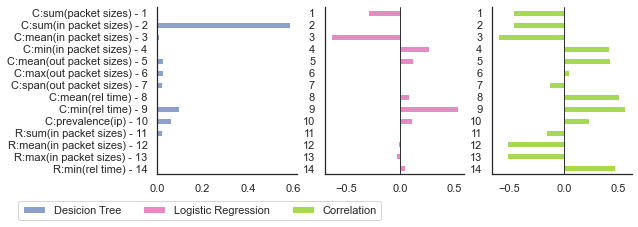

In [204]:
important_features = feature_importance_model(models, X, X_test)
#important_features = important_features.sort_index(ascending=False)
top_important_features = important_features[(important_features['dt_fi'] > 0.02) 
                                            | (important_features['lr_fi'].abs() > 0.02)]
#top_important_features = top_important_features.loc[(top_important_features['dt_fi'] + top_important_features['lr_fi'].abs()).sort_values().index]
top_important_features = top_important_features.iloc[::-1]
cols = ['dt_fi', 'lr_fi', 'correlation']

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(len(cols)*2.5+1,len(top_important_features)*.22))
for i, (ax, color, col) in enumerate(zip(axs, color_cycle[2:], cols)):
    top_important_features[col].plot.barh(color=color, ax=ax)
    
    if i == 0:
        ax.set_yticks(range(len(top_important_features)), [f"{col} - {len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])
    else:
        ax.set_yticks(range(len(top_important_features)), [f"{len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])


#fig.suptitle("Feature importance")
lgd = fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(cols), bbox_to_anchor=(0.5,0.03))
[ax.axvline(0, color='black', linewidth=.8) for ax in axs[1:]]
fig.savefig(ASSETS / f'feature-importance-by-model{CHART_FILE_EXTENSION}', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [41]:
important_features

,dt_fi,dt_pi,lr_pi,lr_fi,correlation
C:count(packets),0.004033,0.028852,0.000000,0.000000,-0.462638
C:count(in packets),0.002236,0.011612,0.000000,0.000000,-0.464437
C:count(out packets),0.008983,0.011087,0.000000,0.000000,-0.342698
C:sum(packet sizes),0.004477,0.013995,0.007155,-0.294728,-0.464982
C:mean(packet sizes),0.005480,0.003894,0.000000,0.000000,-0.574706
C:rsd(packet sizes),0.005243,0.002459,0.000000,0.000000,0.289074
C:min(packet sizes),0.003045,0.002519,0.000000,0.000000,0.454141
C:max(packet sizes),0.001004,0.000926,0.000000,0.000000,-0.377410
C:span(packet sizes),0.001593,0.001563,0.000000,0.000000,-0.476149
C:sum(in packet sizes),0.584698,0.167911,0.000000,0.000000,-0.465152


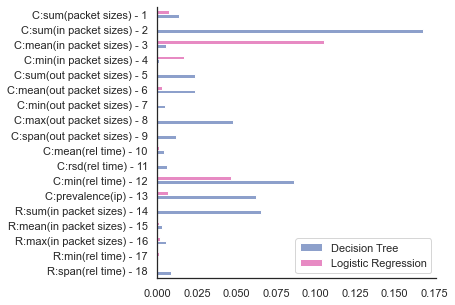

In [42]:
top_important_features[['dt_pi', 'lr_pi']].plot.barh(color=color_cycle[2:], figsize=(5,math.ceil(len(top_important_features)*.25)))
plt.xlim(0)
plt.yticks(range(len(top_important_features)), [f"{col} - {len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])
plt.legend(['Decision Tree', 'Logistic Regression'])
plt.savefig(ASSETS / f'feature-permutation-importance-by-model{CHART_FILE_EXTENSION}', bbox_inches='tight')

In [43]:
mask = list(top_important_features.index[::-1])
X[mask].corr()

,C:sum(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:min(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:prevalence(ip),R:sum(in packet sizes),R:mean(in packet sizes),R:max(in packet sizes),R:min(rel time),R:span(rel time)
C:sum(packet sizes),1.000000,0.999417,0.459431,-0.384240,0.301054,-0.315794,-0.344099,0.112695,0.267684,-0.227283,0.361111,-0.383731,-0.210957,0.191857,0.297006,0.264976,-0.214901,0.020242
C:sum(in packet sizes),0.999417,1.000000,0.460951,-0.381846,0.268330,-0.331507,-0.345086,0.100869,0.257273,-0.228847,0.356123,-0.382075,-0.209025,0.193629,0.299595,0.267400,-0.216740,0.017786
C:mean(in packet sizes),0.459431,0.460951,1.000000,-0.215122,0.088385,-0.433732,-0.394901,-0.094064,0.101662,-0.467831,0.351693,-0.515275,-0.122056,0.208076,0.710464,0.692448,-0.419003,-0.005417
C:min(in packet sizes),-0.384240,-0.381846,-0.215122,1.000000,-0.176294,0.270992,0.431254,-0.132464,-0.327410,0.229047,-0.377093,0.356423,0.241006,-0.117146,-0.083528,-0.127721,0.205534,-0.048529
C:sum(out packet sizes),0.301054,0.268330,0.088385,-0.176294,1.000000,0.349058,-0.070397,0.362499,0.367078,-0.021032,0.242208,-0.155543,-0.114058,0.005106,0.012232,0.007727,-0.009833,0.074363
C:mean(out packet sizes),-0.315794,-0.331507,-0.433732,0.270992,0.349058,1.000000,0.637393,0.568360,0.219157,0.387442,-0.136293,0.354192,-0.008203,-0.128703,-0.324209,-0.315314,0.357565,0.054755
C:min(out packet sizes),-0.344099,-0.345086,-0.394901,0.431254,-0.070397,0.637393,1.000000,0.084017,-0.399292,0.288966,-0.303667,0.370557,0.079465,-0.121624,-0.230214,-0.216594,0.252637,0.003655
C:max(out packet sizes),0.112695,0.100869,-0.094064,-0.132464,0.362499,0.568360,0.084017,1.000000,0.880035,0.163177,0.268394,0.024031,-0.196748,-0.033423,-0.119087,-0.139097,0.160863,0.075284
C:span(out packet sizes),0.267684,0.257273,0.101662,-0.327410,0.367078,0.219157,-0.399292,0.880035,1.000000,0.012416,0.391669,-0.154495,-0.218896,0.027214,0.000149,-0.024753,0.027601,0.067525
C:mean(rel time),-0.227283,-0.228847,-0.467831,0.229047,-0.021032,0.387442,0.288966,0.163177,0.012416,1.000000,-0.344742,0.892974,0.018136,-0.111048,-0.324468,-0.328826,0.900958,0.025415


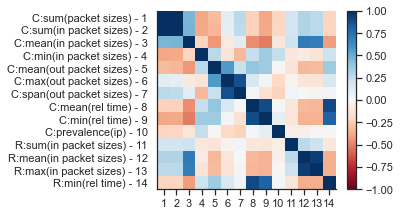

In [206]:
mask = list(top_important_features.index[::-1])
#mask = important_features.index


f = plt.figure(figsize=(math.ceil(len(mask)*.26),math.ceil(len(mask)*.26)))

plt.matshow(X[mask].corr(), fignum=f, cmap='RdBu')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=False,
    labelbottom=True) # labels along the bottom edge are off
plt.xticks(range(len(X[mask].columns)), range(1, len(X[mask].columns)+1))
plt.yticks(range(len(X[mask].columns)), [f"{col} - {i+1}" for i, col in enumerate(X[mask].columns)])
cb = plt.colorbar(shrink=.8)
plt.clim(-1,1)
#cb.ax.tick_params(labelsize=10)
f.savefig(ASSETS / f'feature-cocorrelation{CHART_FILE_EXTENSION}', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Feature Importance Subdataset

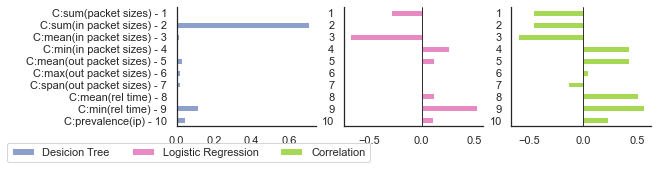

In [45]:
important_features = feature_importance_model(models_com, X, X_test[feature_names['communication']])
#important_features = important_features.sort_index(ascending=False)
top_important_features = important_features[(important_features['dt_fi'] > 0.01) 
                                            | (important_features['lr_fi'].abs() > 0.01)]
#top_important_features = top_important_features.loc[(top_important_features['dt_fi'] + top_important_features['lr_fi'].abs()).sort_values().index]
top_important_features = top_important_features.iloc[::-1]
cols = ['dt_fi', 'lr_fi', 'correlation']

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(len(cols)*2.5+1,len(top_important_features)*.22))
for i, (ax, color, col) in enumerate(zip(axs, color_cycle[2:], cols)):
    top_important_features[col].plot.barh(color=color, ax=ax)
    
    if i == 0:
        ax.set_yticks(range(len(top_important_features)), [f"{col} - {len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])
    else:
        ax.set_yticks(range(len(top_important_features)), [f"{len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])


#fig.suptitle("Feature importance")
lgd = fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(cols), bbox_to_anchor=(0.45,0.055))
[ax.axvline(0, color='black', linewidth=.8) for ax in axs[1:]]
fig.savefig(ASSETS / f'feature-importance-by-model-communication-level{CHART_FILE_EXTENSION}', bbox_extra_artists=(lgd,), bbox_inches='tight')

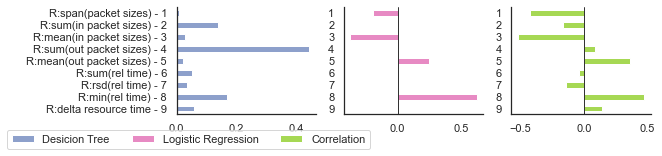

In [46]:
important_features = feature_importance_model(models_res, X, X_test[feature_names['resource']])
#important_features = important_features.sort_index(ascending=False)
top_important_features = important_features[(important_features['dt_fi'] > 0.01) 
                                            | (important_features['lr_fi'].abs() > 0.01)]
#top_important_features = top_important_features.loc[(top_important_features['dt_fi'] + top_important_features['lr_fi'].abs()).sort_values().index]
top_important_features = top_important_features.iloc[::-1]
cols = ['dt_fi', 'lr_fi', 'correlation']

fig, axs = plt.subplots(1, 3, sharey=False, figsize=(len(cols)*2.5+1,len(top_important_features)*.22))
for i, (ax, color, col) in enumerate(zip(axs, color_cycle[2:], cols)):
    top_important_features[col].plot.barh(color=color, ax=ax)
    
    if i == 0:
        ax.set_yticks(range(len(top_important_features)), [f"{col} - {len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])
    else:
        ax.set_yticks(range(len(top_important_features)), [f"{len(top_important_features) - i}" for i, col in enumerate(top_important_features.index)])


#fig.suptitle("Feature importance")
lgd = fig.legend(['Desicion Tree', 'Logistic Regression', 'Correlation'], ncol=len(cols), bbox_to_anchor=(0.45,0.055))
[ax.axvline(0, color='black', linewidth=.8) for ax in axs[1:]]
fig.savefig(ASSETS / f'feature-importance-by-model-resouce-level{CHART_FILE_EXTENSION}', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Leave one feature out

In [47]:
loo_metrics = {}
cols = {'none': []}
for col in feature_names['resource']:
    start = col.find('(')+1
    end = col.find(')')
    fam = col[start:end]
    
    if fam in cols:
        cols[fam].append(col)
    else:
        cols[fam] = [col]
        
for name, col in cols.items():
    X_train_loo = X_train[feature_names['resource']].drop(col, axis=1)
    X_test_loo = X_test[feature_names['resource']].drop(col, axis=1)
    max_depth = max(len(X_train.columns) // 2, 5)
    dt = DecisionTreeClassifier(max_depth=max_depth, class_weight='balanced').fit(X_train_loo, y_train)
    y_pred = dt.predict(X_test_loo)
    loo_metrics[name] = {'acc': accuracy_score(y_test, y_pred), 'f1': f1_score(y_test, y_pred)}

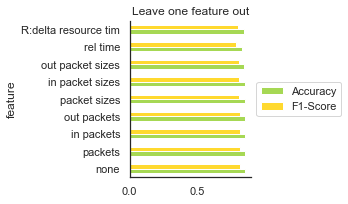

In [48]:
loo_metrics_df = pd.DataFrame(loo_metrics).T
ax = loo_metrics_df.plot.barh(color=color_cycle[4:], figsize=(5,3))
ax.legend(['Accuracy', 'F1-Score'], loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_title("Leave one feature out")
ax.set_ylabel("feature")
plt.tight_layout()
plt.savefig(ASSETS / f'feature-loo-resource{CHART_FILE_EXTENSION}')

## Robustness

### ressource completeness

Drop last perecent of packages. Threshold is defiened as threshold = max(1, int(len(packts) * (1 - percent))). So pruned packets are at most (1 - p) but at least 1 packet.

In [49]:
def drop_last_packets(df, percent=0.1):
    if percent < 0 or percent > 1:
        raise ValueError("No valid percentage was given (between 0 and 1)")
    df = df.copy()
    cols = ['packets', 'sizes', 'ip_src', 'ip_dst', 'rel_time']
    counter = 0
    for index, row in df[cols].iterrows():
        counter += 1
        if counter % (len(df) // 3) == 0:
            print(f"{counter / len(df):.3f}")
        lens = row.apply(len)
        assert lens.eq(lens[0]).all()
        threshold = max(1, int(lens[0] * (1 - percent)))
        df.loc[index, cols] = row.apply(lambda x: x[:threshold])
    
    df['outgoing'] = df.apply(lambda row: [row["packets"][i] for i, ip in enumerate(row["ip_src"])
                                                   if ip.startswith("172.17")], axis=1)
    df['outgoing_sizes'] = df.apply(lambda row: [row["sizes"][i] for i, ip in enumerate(row["ip_src"])
                                                        if ip.startswith("172.17")], axis=1)
    return df

#robustness = []
#for p in np.linspace(0, 1, 11):
#    print(f"Prune p={p:.2f}")
#    df_pruned = drop_last_packets(df_test, p)
#    X_test_pruned = extract_resource_features(df_pruned)
#    results_res = {name: accuracy_score(y_test, model.predict(X_test_pruned)) for model, name in zip(models_res, ['dt_res', 'lr_res'])}
#    results_total = {name: accuracy_score(y_test, model.predict(X_test[feature_names['communication']].join(X_test_pruned))) for model, name in zip(models, ['dt_total', 'lr_total'])}
#    results = results_total | results_res
#    results['prune'] = p
#    robustness.append(results)
    
#robustness = pd.DataFrame(robustness)

In [50]:
#fig, axs = plt.subplots(1, 2, figsize=(12, 4))
#for ax, name, cols in zip(axs, ["all features", "resource level"], [['dt_total', 'lr_total'], ['dt_res', 'lr_res']]):
#    robustness.plot(x='prune', y=cols, color=color_cycle[2:], ax=ax, legend=False)
#    ax.set_ylabel("Accuracy")
#    ax.set_title(name)

#fig.suptitle("Model quality with pruned test data")
#fig.legend(['Desicion Tree', 'Logistic Regression'], ncol=2, bbox_to_anchor=(0.31,0))
#fig.tight_layout()
#fig.savefig(ASSETS / f'feature-pruned-data{CHART_FILE_EXTENSION}')

### Outlier classification

In [51]:
def find_outliers(df, cols=None, fact=1.5):
    if cols is None:
        cols = df.columns
    else:
        q1=df[cols].quantile(0.25)
        q3=df[cols].quantile(0.75)

    IQR=q3-q1
    treash = int(len(cols) * 0.1)
    return df[(df<(q1-fact*IQR)) | (df>(q3+fact*IQR))].dropna(thresh=treash).index


metric_cols = [col for col in X.columns if '(ip)' not in col and ':ip[' not in col and '(org)' not in col]
outliers = find_outliers(X_test, metric_cols, 5)

/var/folders/8x/qb0cq8pd4rq7vy5qvfc3_2vr0000gn/T/ipykernel_94578/1625853396.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[(df<(q1-fact*IQR)) | (df>(q3+fact*IQR))].dropna(thresh=treash).index


In [52]:
corr = X.loc[outliers].copy()
corr['is_tracker'] = y_true
corr.head()

,C:count(packets),C:count(in packets),C:count(out packets),C:sum(packet sizes),C:mean(packet sizes),C:rsd(packet sizes),C:min(packet sizes),C:max(packet sizes),C:span(packet sizes),C:sum(in packet sizes),C:mean(in packet sizes),C:rsd(in packet sizes),C:min(in packet sizes),C:max(in packet sizes),C:span(in packet sizes),C:sum(out packet sizes),C:mean(out packet sizes),C:rsd(out packet sizes),C:min(out packet sizes),C:max(out packet sizes),C:span(out packet sizes),C:sum(rel time),C:mean(rel time),C:rsd(rel time),C:min(rel time),C:max(rel time),C:span(rel time),C:prevalence(ip),R:count(packets),R:count(in packets),R:count(out packets),R:sum(packet sizes),R:mean(packet sizes),R:rsd(packet sizes),R:min(packet sizes),R:max(packet sizes),R:span(packet sizes),R:sum(in packet sizes),R:mean(in packet sizes),R:rsd(in packet sizes),R:min(in packet sizes),R:max(in packet sizes),R:span(in packet sizes),R:sum(out packet sizes),R:mean(out packet sizes),R:rsd(out packet sizes),R:min(out packet sizes),R:max(out packet sizes),R:span(out packet sizes),R:sum(rel time),R:mean(rel time),R:rsd(rel time),R:min(rel time),R:max(rel time),R:span(rel time),R:delta resource time,is_tracker
116671,6,2,4,1321,220.167,0.777,66,567,501,299.0,149.500,0.003,149.0,150.0,1.0,1022,255.500,0.784,66,567,501,66.217,11.036,0.092,10.009,12.069,2.060,12.0,3,1,2,783,261.000,0.839,66,567,501,150.0,150.000,0.000,150.0,150.0,0.0,633.0,316.5,0.791,66.0,567.0,501.0,30.047,10.016,0.001,10.009,10.029,0.020,0.000000,True
211768,1020,975,45,1381531,1354.442,0.245,17,1460,1443,1373123.0,1408.331,0.157,17.0,1460.0,1443.0,8408,186.844,0.631,105,734,629,2274.261,2.230,0.117,1.878,4.117,2.239,-1.0,85,84,1,118955,1399.471,0.175,29,1460,1431,118807.0,1414.369,0.144,29.0,1460.0,1431.0,148.0,148.0,0.000,148.0,148.0,0.0,168.949,1.988,0.005,1.948,2.011,0.063,0.000121,False
190978,2987,2787,200,4150353,1389.472,0.179,5,1460,1455,3904689.0,1401.037,0.156,5.0,1460.0,1455.0,245664,1228.320,0.393,26,1460,1434,11356.255,3.802,0.842,0.169,13.724,13.555,-1.0,7,5,2,8817,1259.571,0.355,167,1460,1293,6007.0,1201.400,0.430,167.0,1460.0,1293.0,2810.0,1405.0,0.039,1350.0,1460.0,110.0,33.207,4.744,0.042,4.431,4.869,0.438,0.001089,False
123335,357,344,13,485400,1359.664,0.213,31,1460,1429,478912.0,1392.186,0.160,31.0,1460.0,1429.0,6488,499.077,0.954,107,1460,1353,2450.202,6.863,0.109,1.465,9.279,7.814,1.0,297,296,1,416790,1403.333,0.146,139,1460,1321,416586.0,1407.385,0.138,139.0,1460.0,1321.0,204.0,204.0,0.000,204.0,204.0,0.0,2049.480,6.901,0.001,6.853,6.912,0.059,0.001474,False
259258,10,4,6,8868,886.800,0.498,346,1460,1114,1623.0,405.750,0.255,346.0,585.0,239.0,7245,1207.500,0.203,839,1460,621,77.936,7.794,0.326,4.414,11.109,6.695,-1.0,4,1,3,4105,1026.250,0.456,346,1460,1114,346.0,346.000,0.000,346.0,346.0,0.0,3759.0,1253.0,0.234,839.0,1460.0,621.0,36.599,9.150,0.006,9.119,9.242,0.123,4.054088,True
